<a href="https://colab.research.google.com/github/Graybang/CM4105-Honours-Project/blob/main/SRGAN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding="same")(ip)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding="same")(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)

    return add([ip, res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

# Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers, temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

# Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides=strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)

    disc_model = LeakyReLU(alpha=0.2)(disc_model)

    return disc_model

# Descriminator as described in the original paper
def create_disc(disc_ip):
    
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation="sigmoid")(d10)

    return Model(disc_ip, validity)

# VGG19 for the feature map

from keras.applications import VGG19

def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

# Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    # losses from generated image and vgg features
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)

    # load generated images into discriminator
    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

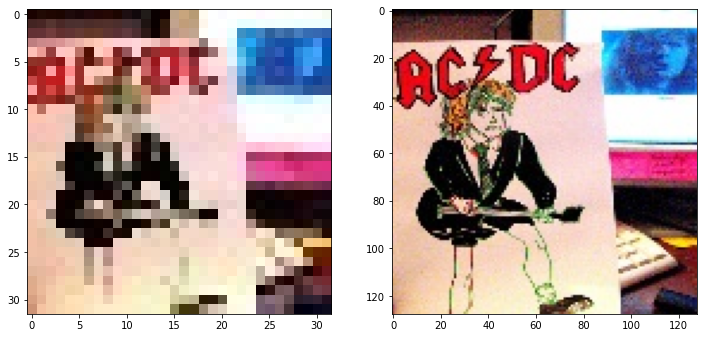

In [2]:
# load the datasets
n=5000
lr_list = os.listdir("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/hr_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

# sanity check, view random images
import random

image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32,32,3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128,128,3)))
plt.show()

In [3]:
# scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

# spit to train and test set
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

# get shape of images
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [4]:
# Generator
generator = create_gen(lr_ip, num_res_block=16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [5]:
# Discriminator
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [6]:
vgg = build_vgg((128,128,3))
vgg.trainable = False
print(vgg.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [7]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [8]:
# create a list of images for LR and HR in batches from which
# a batch of images would be fetched during training
batch_size = 1
train_lr_batches = []
train_hr_batches = []

for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [9]:
from IPython.display import clear_output

epochs = 100
# Enumerate training over epochs
for e in range(epochs):

    # assign a label of 0 to all fake (generated) images
    fake_label = np.zeros((batch_size, 1))
    # assign a label of 1 to all real images
    real_label = np.ones((batch_size,1))

    # create empty lists to populate generator and discriminator losses
    g_losses = []
    d_losses = []

    # Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):

        # Fetch a batch of LR images for training
        lr_imgs = train_lr_batches[b]
        # Fetch a batch of HR images for training
        hr_imgs = train_hr_batches[b]

        # Generated fake images
        fake_imgs = generator.predict_on_batch(lr_imgs) 

        # First, train the discriminator on fake and real HR images
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        # Now, train the generator by fixing the discriminator as non-trainable
        discriminator.trainable = False
        
        # Average the discriminator loss, just for reporting purposes
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        # Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        # Train the generator via GAN
        # remember we have 2 losses
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        # save losses to a list so we can average and report
        g_losses.append(g_loss)
        d_losses.append(d_loss)

    # convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    # calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    # report the progess during training
    clear_output()
    print("epoch:", e+1,"g_loss:", g_loss, "d_loss:", d_loss)

    # save the model after every n epochs (5)
    if (e+1) % 5 == 0:
        generator.save("gen_e_" + str(e+1) + ".h5")

epoch: 21 g_loss: 40.95003348179718 d_loss: [1.00430449e-09 1.00000000e+00]


  0%|                                                                                         | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|                                                                                 | 1/3350 [00:00<25:13,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                                                                 | 2/3350 [00:00<22:43,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


  0%|                                                                                 | 3/3350 [00:01<20:49,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                                                                 | 4/3350 [00:01<19:55,  2.80it/s]

1/1 [==============================] - 0s 48ms/step


  0%|                                                                                 | 5/3350 [00:01<19:34,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▏                                                                                | 6/3350 [00:02<19:16,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                                                                | 7/3350 [00:02<19:07,  2.91it/s]

1/1 [==============================] - 0s 41ms/step


  0%|▏                                                                                | 8/3350 [00:02<19:25,  2.87it/s]

1/1 [==============================] - 0s 52ms/step


  0%|▏                                                                                | 9/3350 [00:03<19:49,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▏                                                                               | 10/3350 [00:03<19:53,  2.80it/s]

1/1 [==============================] - 0s 46ms/step


  0%|▎                                                                               | 11/3350 [00:03<20:07,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                               | 12/3350 [00:04<21:58,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


  0%|▎                                                                               | 13/3350 [00:04<21:49,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


  0%|▎                                                                               | 14/3350 [00:05<20:59,  2.65it/s]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                               | 15/3350 [00:05<20:33,  2.70it/s]

1/1 [==============================] - 0s 49ms/step


  0%|▍                                                                               | 16/3350 [00:05<20:02,  2.77it/s]

1/1 [==============================] - 0s 56ms/step


  1%|▍                                                                               | 17/3350 [00:06<19:46,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▍                                                                               | 18/3350 [00:06<19:41,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▍                                                                               | 19/3350 [00:06<20:24,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▍                                                                               | 20/3350 [00:07<21:27,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▌                                                                               | 21/3350 [00:07<20:51,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▌                                                                               | 22/3350 [00:08<20:34,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▌                                                                               | 23/3350 [00:08<20:23,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▌                                                                               | 24/3350 [00:08<20:17,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▌                                                                               | 25/3350 [00:09<20:03,  2.76it/s]

1/1 [==============================] - 0s 51ms/step


  1%|▌                                                                               | 26/3350 [00:09<20:12,  2.74it/s]

1/1 [==============================] - 0s 54ms/step


  1%|▋                                                                               | 27/3350 [00:09<20:16,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▋                                                                               | 28/3350 [00:10<21:17,  2.60it/s]

1/1 [==============================] - 0s 53ms/step


  1%|▋                                                                               | 29/3350 [00:10<20:58,  2.64it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                               | 30/3350 [00:11<20:31,  2.70it/s]

1/1 [==============================] - 0s 48ms/step


  1%|▋                                                                               | 31/3350 [00:11<20:05,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                               | 32/3350 [00:11<19:56,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                               | 33/3350 [00:12<19:55,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▊                                                                               | 34/3350 [00:12<20:03,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                               | 35/3350 [00:12<20:13,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                               | 36/3350 [00:13<21:28,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                               | 37/3350 [00:13<22:11,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▉                                                                               | 38/3350 [00:14<21:29,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▉                                                                               | 39/3350 [00:14<21:06,  2.62it/s]

1/1 [==============================] - 0s 49ms/step


  1%|▉                                                                               | 40/3350 [00:14<20:49,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                               | 41/3350 [00:15<20:35,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


  1%|█                                                                               | 42/3350 [00:15<21:01,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


  1%|█                                                                               | 43/3350 [00:16<22:26,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


  1%|█                                                                               | 44/3350 [00:16<21:59,  2.51it/s]

1/1 [==============================] - 0s 49ms/step


  1%|█                                                                               | 45/3350 [00:16<21:12,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                               | 46/3350 [00:17<20:32,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                               | 47/3350 [00:17<20:11,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█▏                                                                              | 48/3350 [00:17<20:02,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█▏                                                                              | 49/3350 [00:18<20:07,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█▏                                                                              | 50/3350 [00:18<20:50,  2.64it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▏                                                                              | 51/3350 [00:19<21:03,  2.61it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▏                                                                              | 52/3350 [00:19<20:29,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▎                                                                              | 53/3350 [00:19<20:08,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                              | 54/3350 [00:20<20:00,  2.75it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▎                                                                              | 55/3350 [00:20<19:52,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                              | 56/3350 [00:20<20:27,  2.68it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▎                                                                              | 57/3350 [00:21<20:33,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▍                                                                              | 58/3350 [00:21<20:26,  2.68it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                              | 59/3350 [00:21<20:33,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▍                                                                              | 60/3350 [00:22<22:17,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▍                                                                              | 61/3350 [00:22<21:59,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▍                                                                              | 62/3350 [00:23<21:22,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▌                                                                              | 63/3350 [00:23<20:54,  2.62it/s]

1/1 [==============================] - 0s 55ms/step


  2%|█▌                                                                              | 64/3350 [00:23<20:32,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▌                                                                              | 65/3350 [00:24<20:23,  2.68it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                              | 66/3350 [00:24<22:02,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▌                                                                              | 67/3350 [00:25<22:22,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▌                                                                              | 68/3350 [00:25<21:38,  2.53it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▋                                                                              | 69/3350 [00:25<20:51,  2.62it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▋                                                                              | 70/3350 [00:26<20:18,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▋                                                                              | 71/3350 [00:26<20:09,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                              | 72/3350 [00:27<20:40,  2.64it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▋                                                                              | 73/3350 [00:27<20:46,  2.63it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▊                                                                              | 74/3350 [00:27<20:21,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▊                                                                              | 75/3350 [00:28<20:08,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                              | 76/3350 [00:28<19:48,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


  2%|█▊                                                                              | 77/3350 [00:28<19:48,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▊                                                                              | 78/3350 [00:29<20:31,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                              | 79/3350 [00:29<20:51,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                              | 80/3350 [00:29<20:21,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                              | 81/3350 [00:30<19:53,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                              | 82/3350 [00:30<19:45,  2.76it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                              | 83/3350 [00:31<19:27,  2.80it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██                                                                              | 84/3350 [00:31<19:20,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██                                                                              | 85/3350 [00:31<19:26,  2.80it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██                                                                              | 86/3350 [00:32<19:34,  2.78it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                              | 87/3350 [00:32<21:21,  2.55it/s]

1/1 [==============================] - 0s 48ms/step


  3%|██                                                                              | 88/3350 [00:32<21:57,  2.48it/s]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                             | 89/3350 [00:33<21:17,  2.55it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▏                                                                             | 90/3350 [00:33<20:47,  2.61it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▏                                                                             | 91/3350 [00:34<20:29,  2.65it/s]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                             | 92/3350 [00:34<20:17,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▏                                                                             | 93/3350 [00:34<21:23,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▏                                                                             | 94/3350 [00:35<20:45,  2.61it/s]

1/1 [==============================] - 0s 47ms/step


  3%|██▎                                                                             | 95/3350 [00:35<20:22,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▎                                                                             | 96/3350 [00:35<19:59,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▎                                                                             | 97/3350 [00:36<19:40,  2.75it/s]

1/1 [==============================] - 0s 48ms/step


  3%|██▎                                                                             | 98/3350 [00:36<19:38,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▎                                                                             | 99/3350 [00:37<20:39,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▎                                                                            | 100/3350 [00:37<20:17,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▍                                                                            | 101/3350 [00:37<20:04,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▍                                                                            | 102/3350 [00:38<20:02,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▍                                                                            | 103/3350 [00:38<20:00,  2.71it/s]

1/1 [==============================] - 0s 61ms/step


  3%|██▍                                                                            | 104/3350 [00:38<20:09,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▍                                                                            | 105/3350 [00:39<20:22,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▍                                                                            | 106/3350 [00:39<21:53,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▌                                                                            | 107/3350 [00:40<21:46,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                            | 108/3350 [00:40<21:12,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▌                                                                            | 109/3350 [00:40<20:36,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▌                                                                            | 110/3350 [00:41<20:14,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▌                                                                            | 111/3350 [00:41<19:52,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▋                                                                            | 112/3350 [00:42<20:49,  2.59it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▋                                                                            | 113/3350 [00:42<20:38,  2.61it/s]

1/1 [==============================] - 0s 53ms/step


  3%|██▋                                                                            | 114/3350 [00:42<20:13,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▋                                                                            | 115/3350 [00:43<19:53,  2.71it/s]

1/1 [==============================] - 0s 53ms/step


  3%|██▋                                                                            | 116/3350 [00:43<19:36,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


  3%|██▊                                                                            | 117/3350 [00:43<19:24,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


  4%|██▊                                                                            | 118/3350 [00:44<19:53,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


  4%|██▊                                                                            | 119/3350 [00:44<19:41,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


  4%|██▊                                                                            | 120/3350 [00:44<19:38,  2.74it/s]

1/1 [==============================] - 0s 43ms/step


  4%|██▊                                                                            | 121/3350 [00:45<19:39,  2.74it/s]

1/1 [==============================] - 0s 51ms/step


  4%|██▉                                                                            | 122/3350 [00:45<20:44,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                            | 123/3350 [00:46<20:26,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


  4%|██▉                                                                            | 124/3350 [00:46<20:03,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


  4%|██▉                                                                            | 125/3350 [00:46<19:55,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                            | 126/3350 [00:47<19:49,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


  4%|██▉                                                                            | 127/3350 [00:47<19:42,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                            | 128/3350 [00:47<19:49,  2.71it/s]

1/1 [==============================] - 0s 54ms/step


  4%|███                                                                            | 129/3350 [00:48<19:46,  2.71it/s]

1/1 [==============================] - 0s 49ms/step


  4%|███                                                                            | 130/3350 [00:48<20:42,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███                                                                            | 131/3350 [00:49<20:13,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███                                                                            | 132/3350 [00:49<19:54,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                           | 133/3350 [00:49<19:39,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                           | 134/3350 [00:50<19:34,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


  4%|███▏                                                                           | 135/3350 [00:50<19:26,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▏                                                                           | 136/3350 [00:50<19:24,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███▏                                                                           | 137/3350 [00:51<19:18,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


  4%|███▎                                                                           | 138/3350 [00:51<20:36,  2.60it/s]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                           | 139/3350 [00:52<21:12,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                           | 140/3350 [00:52<20:35,  2.60it/s]

1/1 [==============================] - 0s 48ms/step


  4%|███▎                                                                           | 141/3350 [00:52<20:05,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


  4%|███▎                                                                           | 142/3350 [00:53<19:52,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                           | 143/3350 [00:53<19:43,  2.71it/s]

1/1 [==============================] - 0s 52ms/step


  4%|███▍                                                                           | 144/3350 [00:53<20:26,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▍                                                                           | 145/3350 [00:54<21:44,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


  4%|███▍                                                                           | 146/3350 [00:54<21:32,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


  4%|███▍                                                                           | 147/3350 [00:55<20:47,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


  4%|███▍                                                                           | 148/3350 [00:55<20:01,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


  4%|███▌                                                                           | 149/3350 [00:55<19:44,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███▌                                                                           | 150/3350 [00:56<19:19,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▌                                                                           | 151/3350 [00:56<19:05,  2.79it/s]

1/1 [==============================] - 0s 51ms/step


  5%|███▌                                                                           | 152/3350 [00:56<19:23,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


  5%|███▌                                                                           | 153/3350 [00:57<19:32,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


  5%|███▋                                                                           | 154/3350 [00:57<20:44,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                           | 155/3350 [00:58<20:23,  2.61it/s]

1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                           | 156/3350 [00:58<20:13,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


  5%|███▋                                                                           | 157/3350 [00:58<19:53,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                           | 158/3350 [00:59<19:39,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                           | 159/3350 [00:59<19:43,  2.70it/s]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                           | 160/3350 [00:59<19:40,  2.70it/s]

1/1 [==============================] - 0s 55ms/step


  5%|███▊                                                                           | 161/3350 [01:00<19:46,  2.69it/s]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                           | 162/3350 [01:00<21:32,  2.47it/s]

1/1 [==============================] - 0s 56ms/step


  5%|███▊                                                                           | 163/3350 [01:01<21:26,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                           | 164/3350 [01:01<20:35,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


  5%|███▉                                                                           | 165/3350 [01:01<19:49,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


  5%|███▉                                                                           | 166/3350 [01:02<19:25,  2.73it/s]

1/1 [==============================] - 0s 49ms/step


  5%|███▉                                                                           | 167/3350 [01:02<19:09,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                           | 168/3350 [01:03<19:57,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


  5%|███▉                                                                           | 169/3350 [01:03<20:07,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


  5%|████                                                                           | 170/3350 [01:03<19:31,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████                                                                           | 171/3350 [01:04<19:01,  2.78it/s]

1/1 [==============================] - 0s 48ms/step


  5%|████                                                                           | 172/3350 [01:04<18:50,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


  5%|████                                                                           | 173/3350 [01:04<18:45,  2.82it/s]

1/1 [==============================] - 0s 52ms/step


  5%|████                                                                           | 174/3350 [01:05<18:59,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▏                                                                          | 175/3350 [01:05<19:23,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


  5%|████▏                                                                          | 176/3350 [01:05<20:28,  2.58it/s]

1/1 [==============================] - 0s 58ms/step


  5%|████▏                                                                          | 177/3350 [01:06<20:04,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████▏                                                                          | 178/3350 [01:06<19:40,  2.69it/s]

1/1 [==============================] - 0s 49ms/step


  5%|████▏                                                                          | 179/3350 [01:07<19:33,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                          | 180/3350 [01:07<19:13,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


  5%|████▎                                                                          | 181/3350 [01:07<19:37,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


  5%|████▎                                                                          | 182/3350 [01:08<20:00,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


  5%|████▎                                                                          | 183/3350 [01:08<19:26,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


  5%|████▎                                                                          | 184/3350 [01:08<19:08,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                          | 185/3350 [01:09<18:59,  2.78it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████▍                                                                          | 186/3350 [01:09<18:55,  2.79it/s]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                          | 187/3350 [01:09<18:46,  2.81it/s]

1/1 [==============================] - 0s 58ms/step


  6%|████▍                                                                          | 188/3350 [01:10<18:57,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                          | 189/3350 [01:10<19:53,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


  6%|████▍                                                                          | 190/3350 [01:11<19:29,  2.70it/s]

1/1 [==============================] - 0s 48ms/step


  6%|████▌                                                                          | 191/3350 [01:11<19:07,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                          | 192/3350 [01:11<18:43,  2.81it/s]

1/1 [==============================] - 0s 42ms/step


  6%|████▌                                                                          | 193/3350 [01:12<18:37,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▌                                                                          | 194/3350 [01:12<22:12,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▌                                                                          | 195/3350 [01:13<22:00,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▌                                                                          | 196/3350 [01:13<22:13,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▋                                                                          | 197/3350 [01:13<21:01,  2.50it/s]

1/1 [==============================] - 0s 51ms/step


  6%|████▋                                                                          | 198/3350 [01:14<20:18,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


  6%|████▋                                                                          | 199/3350 [01:14<19:38,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▋                                                                          | 200/3350 [01:14<19:15,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


  6%|████▋                                                                          | 201/3350 [01:15<19:43,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▊                                                                          | 202/3350 [01:15<20:30,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▊                                                                          | 203/3350 [01:16<19:55,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


  6%|████▊                                                                          | 204/3350 [01:16<19:27,  2.69it/s]

1/1 [==============================] - 0s 53ms/step


  6%|████▊                                                                          | 205/3350 [01:16<19:13,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▊                                                                          | 206/3350 [01:17<19:01,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


  6%|████▉                                                                          | 207/3350 [01:17<18:57,  2.76it/s]

1/1 [==============================] - 0s 51ms/step


  6%|████▉                                                                          | 208/3350 [01:17<19:05,  2.74it/s]

1/1 [==============================] - 0s 53ms/step


  6%|████▉                                                                          | 209/3350 [01:18<19:13,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


  6%|████▉                                                                          | 210/3350 [01:18<20:44,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


  6%|████▉                                                                          | 211/3350 [01:19<21:06,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▉                                                                          | 212/3350 [01:19<20:12,  2.59it/s]

1/1 [==============================] - 0s 44ms/step


  6%|█████                                                                          | 213/3350 [01:19<19:39,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████                                                                          | 214/3350 [01:20<19:12,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


  6%|█████                                                                          | 215/3350 [01:20<18:58,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


  6%|█████                                                                          | 216/3350 [01:20<19:27,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████                                                                          | 217/3350 [01:21<20:54,  2.50it/s]

1/1 [==============================] - 0s 50ms/step


  7%|█████▏                                                                         | 218/3350 [01:21<20:38,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


  7%|█████▏                                                                         | 219/3350 [01:22<19:50,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▏                                                                         | 220/3350 [01:22<19:17,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▏                                                                         | 221/3350 [01:22<18:55,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


  7%|█████▏                                                                         | 222/3350 [01:23<18:37,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                         | 223/3350 [01:23<18:38,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


  7%|█████▎                                                                         | 224/3350 [01:23<18:40,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▎                                                                         | 225/3350 [01:24<18:45,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


  7%|█████▎                                                                         | 226/3350 [01:24<20:22,  2.56it/s]

1/1 [==============================] - 0s 52ms/step


  7%|█████▎                                                                         | 227/3350 [01:25<20:52,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▍                                                                         | 228/3350 [01:25<20:03,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▍                                                                         | 229/3350 [01:25<19:31,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                         | 230/3350 [01:26<18:58,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                         | 231/3350 [01:26<18:44,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


  7%|█████▍                                                                         | 232/3350 [01:26<19:14,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


  7%|█████▍                                                                         | 233/3350 [01:27<20:45,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


  7%|█████▌                                                                         | 234/3350 [01:27<20:29,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


  7%|█████▌                                                                         | 235/3350 [01:28<19:48,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▌                                                                         | 236/3350 [01:28<19:10,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▌                                                                         | 237/3350 [01:28<18:41,  2.78it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                         | 238/3350 [01:29<18:20,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                         | 239/3350 [01:29<18:22,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                         | 240/3350 [01:29<18:35,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                         | 241/3350 [01:30<18:54,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                         | 242/3350 [01:30<20:23,  2.54it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                         | 243/3350 [01:31<20:50,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▊                                                                         | 244/3350 [01:31<20:02,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


  7%|█████▊                                                                         | 245/3350 [01:31<19:37,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▊                                                                         | 246/3350 [01:32<19:12,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                         | 247/3350 [01:32<18:53,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                         | 248/3350 [01:32<19:10,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▊                                                                         | 249/3350 [01:33<20:29,  2.52it/s]

1/1 [==============================] - 0s 56ms/step


  7%|█████▉                                                                         | 250/3350 [01:33<20:18,  2.55it/s]

1/1 [==============================] - 0s 46ms/step


  7%|█████▉                                                                         | 251/3350 [01:34<19:27,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


  8%|█████▉                                                                         | 252/3350 [01:34<18:49,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


  8%|█████▉                                                                         | 253/3350 [01:34<18:27,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


  8%|█████▉                                                                         | 254/3350 [01:35<18:10,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████                                                                         | 255/3350 [01:35<18:06,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████                                                                         | 256/3350 [01:35<18:14,  2.83it/s]

1/1 [==============================] - 0s 45ms/step


  8%|██████                                                                         | 257/3350 [01:36<18:29,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


  8%|██████                                                                         | 258/3350 [01:36<19:41,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████                                                                         | 259/3350 [01:37<20:17,  2.54it/s]

1/1 [==============================] - 0s 57ms/step


  8%|██████▏                                                                        | 260/3350 [01:37<19:47,  2.60it/s]

1/1 [==============================] - 0s 54ms/step


  8%|██████▏                                                                        | 261/3350 [01:37<19:34,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▏                                                                        | 262/3350 [01:38<19:06,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


  8%|██████▏                                                                        | 263/3350 [01:38<18:52,  2.73it/s]

1/1 [==============================] - 0s 52ms/step


  8%|██████▏                                                                        | 264/3350 [01:38<19:09,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▏                                                                        | 265/3350 [01:39<19:51,  2.59it/s]

1/1 [==============================] - 0s 56ms/step


  8%|██████▎                                                                        | 266/3350 [01:39<19:30,  2.63it/s]

1/1 [==============================] - 0s 50ms/step


  8%|██████▎                                                                        | 267/3350 [01:40<19:00,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▎                                                                        | 268/3350 [01:40<18:31,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▎                                                                        | 269/3350 [01:40<18:25,  2.79it/s]

1/1 [==============================] - 0s 50ms/step


  8%|██████▎                                                                        | 270/3350 [01:41<18:54,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▍                                                                        | 271/3350 [01:41<19:50,  2.59it/s]

1/1 [==============================] - 0s 46ms/step


  8%|██████▍                                                                        | 272/3350 [01:41<19:11,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


  8%|██████▍                                                                        | 273/3350 [01:42<18:48,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▍                                                                        | 274/3350 [01:42<18:25,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▍                                                                        | 275/3350 [01:42<18:10,  2.82it/s]

1/1 [==============================] - 0s 46ms/step


  8%|██████▌                                                                        | 276/3350 [01:43<18:14,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


  8%|██████▌                                                                        | 277/3350 [01:43<18:18,  2.80it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▌                                                                        | 278/3350 [01:44<18:39,  2.74it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▌                                                                        | 279/3350 [01:44<20:10,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▌                                                                        | 280/3350 [01:44<20:40,  2.48it/s]

1/1 [==============================] - 0s 55ms/step


  8%|██████▋                                                                        | 281/3350 [01:45<19:57,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▋                                                                        | 282/3350 [01:45<19:20,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


  8%|██████▋                                                                        | 283/3350 [01:45<18:59,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▋                                                                        | 284/3350 [01:46<18:44,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


  9%|██████▋                                                                        | 285/3350 [01:46<19:01,  2.68it/s]

1/1 [==============================] - 0s 53ms/step


  9%|██████▋                                                                        | 286/3350 [01:47<19:52,  2.57it/s]

1/1 [==============================] - 0s 59ms/step


  9%|██████▊                                                                        | 287/3350 [01:47<19:32,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


  9%|██████▊                                                                        | 288/3350 [01:47<19:10,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


  9%|██████▊                                                                        | 289/3350 [01:48<18:58,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


  9%|██████▊                                                                        | 290/3350 [01:48<18:53,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


  9%|██████▊                                                                        | 291/3350 [01:49<19:07,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


  9%|██████▉                                                                        | 292/3350 [01:49<19:07,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


  9%|██████▉                                                                        | 293/3350 [01:49<19:05,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


  9%|██████▉                                                                        | 294/3350 [01:50<19:16,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


  9%|██████▉                                                                        | 295/3350 [01:50<20:49,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


  9%|██████▉                                                                        | 296/3350 [01:51<20:27,  2.49it/s]

1/1 [==============================] - 0s 50ms/step


  9%|███████                                                                        | 297/3350 [01:51<19:48,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████                                                                        | 298/3350 [01:51<19:15,  2.64it/s]

1/1 [==============================] - 0s 51ms/step


  9%|███████                                                                        | 299/3350 [01:52<18:59,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


  9%|███████                                                                        | 300/3350 [01:52<18:51,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████                                                                        | 301/3350 [01:52<20:16,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


  9%|███████                                                                        | 302/3350 [01:53<20:52,  2.43it/s]

1/1 [==============================] - 0s 44ms/step


  9%|███████▏                                                                       | 303/3350 [01:53<20:11,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


  9%|███████▏                                                                       | 304/3350 [01:54<19:35,  2.59it/s]

1/1 [==============================] - 0s 47ms/step


  9%|███████▏                                                                       | 305/3350 [01:54<19:09,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


  9%|███████▏                                                                       | 306/3350 [01:54<18:40,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


  9%|███████▏                                                                       | 307/3350 [01:55<19:06,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▎                                                                       | 308/3350 [01:55<19:20,  2.62it/s]

1/1 [==============================] - 0s 48ms/step


  9%|███████▎                                                                       | 309/3350 [01:55<18:50,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


  9%|███████▎                                                                       | 310/3350 [01:56<18:25,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


  9%|███████▎                                                                       | 311/3350 [01:56<18:18,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


  9%|███████▎                                                                       | 312/3350 [01:56<18:05,  2.80it/s]

1/1 [==============================] - 0s 50ms/step


  9%|███████▍                                                                       | 313/3350 [01:57<18:09,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


  9%|███████▍                                                                       | 314/3350 [01:57<18:55,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▍                                                                       | 315/3350 [01:58<19:46,  2.56it/s]

1/1 [==============================] - 0s 47ms/step


  9%|███████▍                                                                       | 316/3350 [01:58<19:13,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


  9%|███████▍                                                                       | 317/3350 [01:58<18:59,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


  9%|███████▍                                                                       | 318/3350 [01:59<18:40,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▌                                                                       | 319/3350 [01:59<18:29,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


 10%|███████▌                                                                       | 320/3350 [02:00<19:37,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


 10%|███████▌                                                                       | 321/3350 [02:00<19:18,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▌                                                                       | 322/3350 [02:00<18:46,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▌                                                                       | 323/3350 [02:01<18:30,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


 10%|███████▋                                                                       | 324/3350 [02:01<18:25,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▋                                                                       | 325/3350 [02:01<18:17,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


 10%|███████▋                                                                       | 326/3350 [02:02<19:27,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 10%|███████▋                                                                       | 327/3350 [02:02<19:11,  2.62it/s]

1/1 [==============================] - 0s 48ms/step


 10%|███████▋                                                                       | 328/3350 [02:03<18:58,  2.65it/s]

1/1 [==============================] - 0s 48ms/step


 10%|███████▊                                                                       | 329/3350 [02:03<18:47,  2.68it/s]

1/1 [==============================] - 0s 55ms/step


 10%|███████▊                                                                       | 330/3350 [02:03<18:52,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 10%|███████▊                                                                       | 331/3350 [02:04<18:50,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 10%|███████▊                                                                       | 332/3350 [02:04<18:55,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 10%|███████▊                                                                       | 333/3350 [02:04<20:17,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 10%|███████▉                                                                       | 334/3350 [02:05<20:02,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 10%|███████▉                                                                       | 335/3350 [02:05<19:19,  2.60it/s]

1/1 [==============================] - 0s 47ms/step


 10%|███████▉                                                                       | 336/3350 [02:06<18:44,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


 10%|███████▉                                                                       | 337/3350 [02:06<18:21,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


 10%|███████▉                                                                       | 338/3350 [02:06<18:14,  2.75it/s]

1/1 [==============================] - 0s 51ms/step


 10%|███████▉                                                                       | 339/3350 [02:07<18:13,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


 10%|████████                                                                       | 340/3350 [02:07<18:50,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 10%|████████                                                                       | 341/3350 [02:07<19:41,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 10%|████████                                                                       | 342/3350 [02:08<19:10,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████                                                                       | 343/3350 [02:08<18:36,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


 10%|████████                                                                       | 344/3350 [02:09<18:21,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▏                                                                      | 345/3350 [02:09<18:11,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 10%|████████▏                                                                      | 346/3350 [02:09<18:06,  2.77it/s]

1/1 [==============================] - 0s 48ms/step


 10%|████████▏                                                                      | 347/3350 [02:10<18:12,  2.75it/s]

1/1 [==============================] - 0s 54ms/step


 10%|████████▏                                                                      | 348/3350 [02:10<18:16,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▏                                                                      | 349/3350 [02:10<19:15,  2.60it/s]

1/1 [==============================] - 0s 51ms/step


 10%|████████▎                                                                      | 350/3350 [02:11<18:43,  2.67it/s]

1/1 [==============================] - 0s 47ms/step


 10%|████████▎                                                                      | 351/3350 [02:11<18:24,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 11%|████████▎                                                                      | 352/3350 [02:11<18:15,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


 11%|████████▎                                                                      | 353/3350 [02:12<18:08,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 11%|████████▎                                                                      | 354/3350 [02:12<18:03,  2.77it/s]

1/1 [==============================] - 0s 57ms/step


 11%|████████▎                                                                      | 355/3350 [02:13<18:14,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 11%|████████▍                                                                      | 356/3350 [02:13<18:21,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▍                                                                      | 357/3350 [02:13<19:47,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


 11%|████████▍                                                                      | 358/3350 [02:14<20:07,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 11%|████████▍                                                                      | 359/3350 [02:14<19:30,  2.56it/s]

1/1 [==============================] - 0s 44ms/step


 11%|████████▍                                                                      | 360/3350 [02:15<18:53,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▌                                                                      | 361/3350 [02:15<18:21,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▌                                                                      | 362/3350 [02:15<17:59,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 11%|████████▌                                                                      | 363/3350 [02:16<18:30,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 11%|████████▌                                                                      | 364/3350 [02:16<19:17,  2.58it/s]

1/1 [==============================] - 0s 42ms/step


 11%|████████▌                                                                      | 365/3350 [02:16<18:54,  2.63it/s]

1/1 [==============================] - 0s 47ms/step


 11%|████████▋                                                                      | 366/3350 [02:17<18:44,  2.65it/s]

1/1 [==============================] - 0s 54ms/step


 11%|████████▋                                                                      | 367/3350 [02:17<18:26,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 11%|████████▋                                                                      | 368/3350 [02:17<18:08,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 11%|████████▋                                                                      | 369/3350 [02:18<18:58,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 11%|████████▋                                                                      | 370/3350 [02:18<18:59,  2.61it/s]

1/1 [==============================] - 0s 49ms/step


 11%|████████▋                                                                      | 371/3350 [02:19<18:34,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


 11%|████████▊                                                                      | 372/3350 [02:19<18:13,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


 11%|████████▊                                                                      | 373/3350 [02:19<17:47,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 11%|████████▊                                                                      | 374/3350 [02:20<17:31,  2.83it/s]

1/1 [==============================] - 0s 51ms/step


 11%|████████▊                                                                      | 375/3350 [02:20<17:26,  2.84it/s]

1/1 [==============================] - 0s 48ms/step


 11%|████████▊                                                                      | 376/3350 [02:20<17:40,  2.80it/s]

1/1 [==============================] - 0s 42ms/step


 11%|████████▉                                                                      | 377/3350 [02:21<17:42,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 11%|████████▉                                                                      | 378/3350 [02:21<19:14,  2.57it/s]

1/1 [==============================] - 0s 42ms/step


 11%|████████▉                                                                      | 379/3350 [02:22<19:44,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 11%|████████▉                                                                      | 380/3350 [02:22<19:07,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▉                                                                      | 381/3350 [02:22<18:25,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█████████                                                                      | 382/3350 [02:23<17:53,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████                                                                      | 383/3350 [02:23<17:32,  2.82it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█████████                                                                      | 384/3350 [02:23<17:52,  2.77it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█████████                                                                      | 385/3350 [02:24<18:50,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████                                                                      | 386/3350 [02:24<18:18,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▏                                                                     | 387/3350 [02:25<17:56,  2.75it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█████████▏                                                                     | 388/3350 [02:25<17:37,  2.80it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█████████▏                                                                     | 389/3350 [02:25<17:25,  2.83it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█████████▏                                                                     | 390/3350 [02:26<18:06,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▏                                                                     | 391/3350 [02:26<19:00,  2.59it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█████████▏                                                                     | 392/3350 [02:26<18:33,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█████████▎                                                                     | 393/3350 [02:27<18:17,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█████████▎                                                                     | 394/3350 [02:27<17:53,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▎                                                                     | 395/3350 [02:27<17:51,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████▎                                                                     | 396/3350 [02:28<17:47,  2.77it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█████████▎                                                                     | 397/3350 [02:28<17:46,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▍                                                                     | 398/3350 [02:29<17:59,  2.73it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▍                                                                     | 399/3350 [02:29<19:27,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▍                                                                     | 400/3350 [02:29<19:54,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▍                                                                     | 401/3350 [02:30<19:06,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█████████▍                                                                     | 402/3350 [02:30<18:36,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█████████▌                                                                     | 403/3350 [02:30<18:09,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█████████▌                                                                     | 404/3350 [02:31<17:50,  2.75it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█████████▌                                                                     | 405/3350 [02:31<18:14,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▌                                                                     | 406/3350 [02:32<19:13,  2.55it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▌                                                                     | 407/3350 [02:32<18:59,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████▌                                                                     | 408/3350 [02:32<18:26,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█████████▋                                                                     | 409/3350 [02:33<18:16,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█████████▋                                                                     | 410/3350 [02:33<18:15,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█████████▋                                                                     | 411/3350 [02:34<18:38,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█████████▋                                                                     | 412/3350 [02:34<18:37,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▋                                                                     | 413/3350 [02:34<18:42,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▊                                                                     | 414/3350 [02:35<19:11,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█████████▊                                                                     | 415/3350 [02:35<20:26,  2.39it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█████████▊                                                                     | 416/3350 [02:36<20:39,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████▊                                                                     | 417/3350 [02:36<19:34,  2.50it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█████████▊                                                                     | 418/3350 [02:36<18:59,  2.57it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▉                                                                     | 419/3350 [02:37<18:30,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█████████▉                                                                     | 420/3350 [02:37<18:01,  2.71it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▉                                                                     | 421/3350 [02:37<17:47,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█████████▉                                                                     | 422/3350 [02:38<17:53,  2.73it/s]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▉                                                                     | 423/3350 [02:38<18:03,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█████████▉                                                                     | 424/3350 [02:39<19:32,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 13%|██████████                                                                     | 425/3350 [02:39<19:57,  2.44it/s]

1/1 [==============================] - 0s 48ms/step


 13%|██████████                                                                     | 426/3350 [02:39<19:07,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 13%|██████████                                                                     | 427/3350 [02:40<18:36,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 13%|██████████                                                                     | 428/3350 [02:40<18:13,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 13%|██████████                                                                     | 429/3350 [02:40<17:54,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 13%|██████████▏                                                                    | 430/3350 [02:41<18:23,  2.65it/s]

1/1 [==============================] - 0s 52ms/step


 13%|██████████▏                                                                    | 431/3350 [02:41<18:43,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▏                                                                    | 432/3350 [02:42<18:11,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 13%|██████████▏                                                                    | 433/3350 [02:42<17:57,  2.71it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▏                                                                    | 434/3350 [02:42<17:52,  2.72it/s]

1/1 [==============================] - 0s 48ms/step


 13%|██████████▎                                                                    | 435/3350 [02:43<17:39,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▎                                                                    | 436/3350 [02:43<18:14,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 13%|██████████▎                                                                    | 437/3350 [02:43<18:29,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


 13%|██████████▎                                                                    | 438/3350 [02:44<18:00,  2.69it/s]

1/1 [==============================] - 0s 55ms/step


 13%|██████████▎                                                                    | 439/3350 [02:44<17:45,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▍                                                                    | 440/3350 [02:45<17:38,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                    | 441/3350 [02:45<17:22,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


 13%|██████████▍                                                                    | 442/3350 [02:45<17:11,  2.82it/s]

1/1 [==============================] - 0s 60ms/step


 13%|██████████▍                                                                    | 443/3350 [02:46<17:31,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


 13%|██████████▍                                                                    | 444/3350 [02:46<17:45,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


 13%|██████████▍                                                                    | 445/3350 [02:46<18:41,  2.59it/s]

1/1 [==============================] - 0s 46ms/step


 13%|██████████▌                                                                    | 446/3350 [02:47<18:06,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▌                                                                    | 447/3350 [02:47<17:47,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 13%|██████████▌                                                                    | 448/3350 [02:47<17:40,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


 13%|██████████▌                                                                    | 449/3350 [02:48<17:37,  2.74it/s]

1/1 [==============================] - 0s 50ms/step


 13%|██████████▌                                                                    | 450/3350 [02:48<17:28,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 13%|██████████▋                                                                    | 451/3350 [02:49<17:25,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▋                                                                    | 452/3350 [02:49<17:40,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 14%|██████████▋                                                                    | 453/3350 [02:49<19:16,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 14%|██████████▋                                                                    | 454/3350 [02:50<19:46,  2.44it/s]

1/1 [==============================] - 0s 60ms/step


 14%|██████████▋                                                                    | 455/3350 [02:50<19:16,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 14%|██████████▊                                                                    | 456/3350 [02:51<18:34,  2.60it/s]

1/1 [==============================] - 0s 46ms/step


 14%|██████████▊                                                                    | 457/3350 [02:51<18:15,  2.64it/s]

1/1 [==============================] - 0s 44ms/step


 14%|██████████▊                                                                    | 458/3350 [02:51<17:54,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


 14%|██████████▊                                                                    | 459/3350 [02:52<18:49,  2.56it/s]

1/1 [==============================] - 0s 47ms/step


 14%|██████████▊                                                                    | 460/3350 [02:52<18:29,  2.61it/s]

1/1 [==============================] - 0s 46ms/step


 14%|██████████▊                                                                    | 461/3350 [02:52<18:08,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 14%|██████████▉                                                                    | 462/3350 [02:53<18:00,  2.67it/s]

1/1 [==============================] - 0s 47ms/step


 14%|██████████▉                                                                    | 463/3350 [02:53<17:40,  2.72it/s]

1/1 [==============================] - 0s 57ms/step


 14%|██████████▉                                                                    | 464/3350 [02:54<17:29,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 14%|██████████▉                                                                    | 465/3350 [02:54<21:15,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▉                                                                    | 466/3350 [02:55<20:14,  2.37it/s]

1/1 [==============================] - 0s 54ms/step


 14%|███████████                                                                    | 467/3350 [02:55<19:49,  2.42it/s]

1/1 [==============================] - 0s 43ms/step


 14%|███████████                                                                    | 468/3350 [02:55<20:41,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████                                                                    | 469/3350 [02:56<20:37,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████                                                                    | 470/3350 [02:56<19:34,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████                                                                    | 471/3350 [02:57<18:53,  2.54it/s]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▏                                                                   | 472/3350 [02:57<18:22,  2.61it/s]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▏                                                                   | 473/3350 [02:57<17:58,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▏                                                                   | 474/3350 [02:58<18:21,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▏                                                                   | 475/3350 [02:58<19:30,  2.46it/s]

1/1 [==============================] - 0s 51ms/step


 14%|███████████▏                                                                   | 476/3350 [02:58<18:53,  2.53it/s]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▏                                                                   | 477/3350 [02:59<18:13,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                   | 478/3350 [02:59<17:39,  2.71it/s]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                   | 479/3350 [03:00<17:26,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                   | 480/3350 [03:00<17:17,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                   | 481/3350 [03:00<17:41,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                   | 482/3350 [03:01<17:57,  2.66it/s]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▍                                                                   | 483/3350 [03:01<17:39,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▍                                                                   | 484/3350 [03:01<17:17,  2.76it/s]

1/1 [==============================] - 0s 53ms/step


 14%|███████████▍                                                                   | 485/3350 [03:02<17:04,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


 15%|███████████▍                                                                   | 486/3350 [03:02<16:59,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 15%|███████████▍                                                                   | 487/3350 [03:02<17:02,  2.80it/s]

1/1 [==============================] - 0s 39ms/step


 15%|███████████▌                                                                   | 488/3350 [03:03<18:03,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 15%|███████████▌                                                                   | 489/3350 [03:03<17:45,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


 15%|███████████▌                                                                   | 490/3350 [03:04<17:30,  2.72it/s]

1/1 [==============================] - 0s 54ms/step


 15%|███████████▌                                                                   | 491/3350 [03:04<17:24,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 15%|███████████▌                                                                   | 492/3350 [03:04<17:14,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


 15%|███████████▋                                                                   | 493/3350 [03:05<17:04,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 15%|███████████▋                                                                   | 494/3350 [03:05<17:11,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 15%|███████████▋                                                                   | 495/3350 [03:05<17:45,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▋                                                                   | 496/3350 [03:06<18:30,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 15%|███████████▋                                                                   | 497/3350 [03:06<17:52,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 15%|███████████▋                                                                   | 498/3350 [03:07<17:31,  2.71it/s]

1/1 [==============================] - 0s 46ms/step


 15%|███████████▊                                                                   | 499/3350 [03:07<17:19,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


 15%|███████████▊                                                                   | 500/3350 [03:07<17:01,  2.79it/s]

1/1 [==============================] - 0s 46ms/step


 15%|███████████▊                                                                   | 501/3350 [03:08<17:29,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 15%|███████████▊                                                                   | 502/3350 [03:08<17:47,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 15%|███████████▊                                                                   | 503/3350 [03:08<18:18,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 15%|███████████▉                                                                   | 504/3350 [03:09<17:46,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 15%|███████████▉                                                                   | 505/3350 [03:09<17:22,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


 15%|███████████▉                                                                   | 506/3350 [03:09<16:58,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


 15%|███████████▉                                                                   | 507/3350 [03:10<16:45,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 15%|███████████▉                                                                   | 508/3350 [03:10<17:16,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


 15%|████████████                                                                   | 509/3350 [03:11<18:07,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 15%|████████████                                                                   | 510/3350 [03:11<17:43,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 15%|████████████                                                                   | 511/3350 [03:11<17:24,  2.72it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████                                                                   | 512/3350 [03:12<17:14,  2.74it/s]

1/1 [==============================] - 0s 43ms/step


 15%|████████████                                                                   | 513/3350 [03:12<17:04,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████                                                                   | 514/3350 [03:12<17:24,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 15%|████████████▏                                                                  | 515/3350 [03:13<18:09,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▏                                                                  | 516/3350 [03:13<17:40,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 15%|████████████▏                                                                  | 517/3350 [03:14<17:18,  2.73it/s]

1/1 [==============================] - 0s 52ms/step


 15%|████████████▏                                                                  | 518/3350 [03:14<17:05,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                  | 519/3350 [03:14<16:59,  2.78it/s]

1/1 [==============================] - 0s 49ms/step


 16%|████████████▎                                                                  | 520/3350 [03:15<17:02,  2.77it/s]

1/1 [==============================] - 0s 53ms/step


 16%|████████████▎                                                                  | 521/3350 [03:15<17:10,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▎                                                                  | 522/3350 [03:15<17:19,  2.72it/s]

1/1 [==============================] - 0s 39ms/step


 16%|████████████▎                                                                  | 523/3350 [03:16<18:48,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 16%|████████████▎                                                                  | 524/3350 [03:16<19:43,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 16%|████████████▍                                                                  | 525/3350 [03:17<19:12,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▍                                                                  | 526/3350 [03:17<18:13,  2.58it/s]

1/1 [==============================] - 0s 53ms/step


 16%|████████████▍                                                                  | 527/3350 [03:17<17:37,  2.67it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▍                                                                  | 528/3350 [03:18<17:07,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


 16%|████████████▍                                                                  | 529/3350 [03:18<16:44,  2.81it/s]

1/1 [==============================] - 0s 46ms/step


 16%|████████████▍                                                                  | 530/3350 [03:18<17:06,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▌                                                                  | 531/3350 [03:19<17:07,  2.74it/s]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▌                                                                  | 532/3350 [03:19<17:37,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▌                                                                  | 533/3350 [03:20<18:26,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


 16%|████████████▌                                                                  | 534/3350 [03:20<17:49,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▌                                                                  | 535/3350 [03:20<17:24,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▋                                                                  | 536/3350 [03:21<17:06,  2.74it/s]

1/1 [==============================] - 0s 45ms/step


 16%|████████████▋                                                                  | 537/3350 [03:21<17:00,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


 16%|████████████▋                                                                  | 538/3350 [03:21<17:25,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 16%|████████████▋                                                                  | 539/3350 [03:22<18:16,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 16%|████████████▋                                                                  | 540/3350 [03:22<17:45,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 16%|████████████▊                                                                  | 541/3350 [03:23<17:21,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 16%|████████████▊                                                                  | 542/3350 [03:23<17:09,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 16%|████████████▊                                                                  | 543/3350 [03:23<16:56,  2.76it/s]

1/1 [==============================] - 0s 54ms/step


 16%|████████████▊                                                                  | 544/3350 [03:24<16:54,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▊                                                                  | 545/3350 [03:24<16:57,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 16%|████████████▉                                                                  | 546/3350 [03:24<17:12,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 16%|████████████▉                                                                  | 547/3350 [03:25<18:10,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 16%|████████████▉                                                                  | 548/3350 [03:25<17:43,  2.63it/s]

1/1 [==============================] - 0s 53ms/step


 16%|████████████▉                                                                  | 549/3350 [03:26<17:26,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


 16%|████████████▉                                                                  | 550/3350 [03:26<17:19,  2.69it/s]

1/1 [==============================] - 0s 55ms/step


 16%|████████████▉                                                                  | 551/3350 [03:26<17:25,  2.68it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█████████████                                                                  | 552/3350 [03:27<17:30,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█████████████                                                                  | 553/3350 [03:27<17:30,  2.66it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████                                                                  | 554/3350 [03:27<17:37,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█████████████                                                                  | 555/3350 [03:28<19:06,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████                                                                  | 556/3350 [03:28<19:00,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▏                                                                 | 557/3350 [03:29<18:23,  2.53it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▏                                                                 | 558/3350 [03:29<18:08,  2.56it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████▏                                                                 | 559/3350 [03:29<17:46,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▏                                                                 | 560/3350 [03:30<17:31,  2.65it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█████████████▏                                                                 | 561/3350 [03:30<18:29,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█████████████▎                                                                 | 562/3350 [03:31<17:57,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████▎                                                                 | 563/3350 [03:31<17:36,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▎                                                                 | 564/3350 [03:31<17:32,  2.65it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█████████████▎                                                                 | 565/3350 [03:32<17:17,  2.69it/s]

1/1 [==============================] - 0s 59ms/step


 17%|█████████████▎                                                                 | 566/3350 [03:32<17:08,  2.71it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▎                                                                 | 567/3350 [03:32<17:05,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▍                                                                 | 568/3350 [03:33<17:16,  2.68it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▍                                                                 | 569/3350 [03:33<18:09,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████▍                                                                 | 570/3350 [03:34<17:48,  2.60it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█████████████▍                                                                 | 571/3350 [03:34<17:29,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████▍                                                                 | 572/3350 [03:34<17:12,  2.69it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████▌                                                                 | 573/3350 [03:35<17:10,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▌                                                                 | 574/3350 [03:35<16:59,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▌                                                                 | 575/3350 [03:35<16:59,  2.72it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█████████████▌                                                                 | 576/3350 [03:36<16:59,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▌                                                                 | 577/3350 [03:36<18:00,  2.57it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█████████████▋                                                                 | 578/3350 [03:37<17:42,  2.61it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▋                                                                 | 579/3350 [03:37<17:28,  2.64it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▋                                                                 | 580/3350 [03:37<17:11,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█████████████▋                                                                 | 581/3350 [03:38<16:59,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▋                                                                 | 582/3350 [03:38<17:01,  2.71it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█████████████▋                                                                 | 583/3350 [03:38<17:06,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▊                                                                 | 584/3350 [03:39<17:07,  2.69it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████▊                                                                 | 585/3350 [03:39<18:05,  2.55it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█████████████▊                                                                 | 586/3350 [03:40<17:40,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▊                                                                 | 587/3350 [03:40<17:20,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█████████████▊                                                                 | 588/3350 [03:40<17:11,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█████████████▉                                                                 | 589/3350 [03:41<16:56,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█████████████▉                                                                 | 590/3350 [03:41<16:57,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█████████████▉                                                                 | 591/3350 [03:41<16:55,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▉                                                                 | 592/3350 [03:42<16:59,  2.71it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▉                                                                 | 593/3350 [03:42<17:57,  2.56it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████                                                                 | 594/3350 [03:43<17:32,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████                                                                 | 595/3350 [03:43<17:16,  2.66it/s]

1/1 [==============================] - 0s 55ms/step


 18%|██████████████                                                                 | 596/3350 [03:43<17:03,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████                                                                 | 597/3350 [03:44<16:48,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████                                                                 | 598/3350 [03:44<16:39,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▏                                                                | 599/3350 [03:44<16:38,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


 18%|██████████████▏                                                                | 600/3350 [03:45<16:43,  2.74it/s]

1/1 [==============================] - 0s 53ms/step


 18%|██████████████▏                                                                | 601/3350 [03:45<17:59,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▏                                                                | 602/3350 [03:46<18:33,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▏                                                                | 603/3350 [03:46<17:53,  2.56it/s]

1/1 [==============================] - 0s 57ms/step


 18%|██████████████▏                                                                | 604/3350 [03:46<17:30,  2.61it/s]

1/1 [==============================] - 0s 44ms/step


 18%|██████████████▎                                                                | 605/3350 [03:47<17:10,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 18%|██████████████▎                                                                | 606/3350 [03:47<16:53,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▎                                                                | 607/3350 [03:47<17:24,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▎                                                                | 608/3350 [03:48<17:34,  2.60it/s]

1/1 [==============================] - 0s 50ms/step


 18%|██████████████▎                                                                | 609/3350 [03:48<17:11,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


 18%|██████████████▍                                                                | 610/3350 [03:49<16:58,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████▍                                                                | 611/3350 [03:49<16:41,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


 18%|██████████████▍                                                                | 612/3350 [03:49<16:19,  2.80it/s]

1/1 [==============================] - 0s 50ms/step


 18%|██████████████▍                                                                | 613/3350 [03:50<16:47,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████▍                                                                | 614/3350 [03:50<16:51,  2.71it/s]

1/1 [==============================] - 0s 57ms/step


 18%|██████████████▌                                                                | 615/3350 [03:50<16:58,  2.69it/s]

1/1 [==============================] - 0s 52ms/step


 18%|██████████████▌                                                                | 616/3350 [03:51<17:04,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 18%|██████████████▌                                                                | 617/3350 [03:51<18:19,  2.49it/s]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████▌                                                                | 618/3350 [03:52<18:24,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▌                                                                | 619/3350 [03:52<17:50,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 19%|██████████████▌                                                                | 620/3350 [03:52<17:22,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 19%|██████████████▋                                                                | 621/3350 [03:53<17:02,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 19%|██████████████▋                                                                | 622/3350 [03:53<16:51,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 19%|██████████████▋                                                                | 623/3350 [03:54<18:08,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 19%|██████████████▋                                                                | 624/3350 [03:54<18:28,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 19%|██████████████▋                                                                | 625/3350 [03:54<17:33,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 19%|██████████████▊                                                                | 626/3350 [03:55<16:48,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 19%|██████████████▊                                                                | 627/3350 [03:55<16:23,  2.77it/s]

1/1 [==============================] - 0s 57ms/step


 19%|██████████████▊                                                                | 628/3350 [03:55<16:19,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 19%|██████████████▊                                                                | 629/3350 [03:56<16:42,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 19%|██████████████▊                                                                | 630/3350 [03:56<17:31,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 19%|██████████████▉                                                                | 631/3350 [03:57<17:08,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 19%|██████████████▉                                                                | 632/3350 [03:57<16:48,  2.69it/s]

1/1 [==============================] - 0s 47ms/step


 19%|██████████████▉                                                                | 633/3350 [03:57<16:33,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 19%|██████████████▉                                                                | 634/3350 [03:58<16:24,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


 19%|██████████████▉                                                                | 635/3350 [03:58<16:55,  2.67it/s]

1/1 [==============================] - 0s 50ms/step


 19%|██████████████▉                                                                | 636/3350 [03:58<16:55,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 19%|███████████████                                                                | 637/3350 [03:59<17:23,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████████████                                                                | 638/3350 [03:59<18:28,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 19%|███████████████                                                                | 639/3350 [04:00<18:14,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


 19%|███████████████                                                                | 640/3350 [04:00<17:30,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████████████                                                                | 641/3350 [04:00<16:50,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████████████▏                                                               | 642/3350 [04:01<16:25,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 19%|███████████████▏                                                               | 643/3350 [04:01<16:08,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▏                                                               | 644/3350 [04:01<16:06,  2.80it/s]

1/1 [==============================] - 0s 42ms/step


 19%|███████████████▏                                                               | 645/3350 [04:02<16:12,  2.78it/s]

1/1 [==============================] - 0s 58ms/step


 19%|███████████████▏                                                               | 646/3350 [04:02<16:20,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


 19%|███████████████▎                                                               | 647/3350 [04:03<17:41,  2.55it/s]

1/1 [==============================] - 0s 42ms/step


 19%|███████████████▎                                                               | 648/3350 [04:03<18:02,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 19%|███████████████▎                                                               | 649/3350 [04:03<17:19,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████████████▎                                                               | 650/3350 [04:04<16:49,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████████████▎                                                               | 651/3350 [04:04<16:32,  2.72it/s]

1/1 [==============================] - 0s 44ms/step


 19%|███████████████▍                                                               | 652/3350 [04:04<16:16,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


 19%|███████████████▍                                                               | 653/3350 [04:05<16:38,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████████████▍                                                               | 654/3350 [04:05<17:02,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████████████▍                                                               | 655/3350 [04:06<17:45,  2.53it/s]

1/1 [==============================] - 0s 56ms/step


 20%|███████████████▍                                                               | 656/3350 [04:06<17:08,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 20%|███████████████▍                                                               | 657/3350 [04:06<16:40,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


 20%|███████████████▌                                                               | 658/3350 [04:07<16:30,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████████████▌                                                               | 659/3350 [04:07<16:20,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▌                                                               | 660/3350 [04:07<16:19,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


 20%|███████████████▌                                                               | 661/3350 [04:08<16:30,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


 20%|███████████████▌                                                               | 662/3350 [04:08<16:29,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████████████▋                                                               | 663/3350 [04:09<17:25,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 20%|███████████████▋                                                               | 664/3350 [04:09<16:56,  2.64it/s]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▋                                                               | 665/3350 [04:09<16:49,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▋                                                               | 666/3350 [04:10<16:51,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████████████▋                                                               | 667/3350 [04:10<16:45,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


 20%|███████████████▊                                                               | 668/3350 [04:10<16:29,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 20%|███████████████▊                                                               | 669/3350 [04:11<16:32,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████████████▊                                                               | 670/3350 [04:11<16:29,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████████████▊                                                               | 671/3350 [04:12<17:22,  2.57it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████████████▊                                                               | 672/3350 [04:12<16:58,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▊                                                               | 673/3350 [04:12<16:40,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████████████▉                                                               | 674/3350 [04:13<16:27,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


 20%|███████████████▉                                                               | 675/3350 [04:13<16:16,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


 20%|███████████████▉                                                               | 676/3350 [04:13<16:10,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 20%|███████████████▉                                                               | 677/3350 [04:14<16:17,  2.73it/s]

1/1 [==============================] - 0s 53ms/step


 20%|███████████████▉                                                               | 678/3350 [04:14<16:24,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████                                                               | 679/3350 [04:15<17:49,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 20%|████████████████                                                               | 680/3350 [04:15<18:47,  2.37it/s]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████                                                               | 681/3350 [04:15<18:25,  2.41it/s]

1/1 [==============================] - 0s 52ms/step


 20%|████████████████                                                               | 682/3350 [04:16<17:41,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 20%|████████████████                                                               | 683/3350 [04:16<17:09,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▏                                                              | 684/3350 [04:17<16:33,  2.68it/s]

1/1 [==============================] - 0s 55ms/step


 20%|████████████████▏                                                              | 685/3350 [04:17<16:20,  2.72it/s]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▏                                                              | 686/3350 [04:17<16:35,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 21%|████████████████▏                                                              | 687/3350 [04:18<16:24,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▏                                                              | 688/3350 [04:18<16:18,  2.72it/s]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▏                                                              | 689/3350 [04:18<16:26,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 21%|████████████████▎                                                              | 690/3350 [04:19<17:24,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 21%|████████████████▎                                                              | 691/3350 [04:19<17:02,  2.60it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████████████▎                                                              | 692/3350 [04:20<16:46,  2.64it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████████████▎                                                              | 693/3350 [04:20<16:25,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▎                                                              | 694/3350 [04:20<16:15,  2.72it/s]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▍                                                              | 695/3350 [04:21<16:01,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████████████▍                                                              | 696/3350 [04:21<16:13,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████████████▍                                                              | 697/3350 [04:21<16:17,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▍                                                              | 698/3350 [04:22<17:08,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▍                                                              | 699/3350 [04:22<16:48,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▌                                                              | 700/3350 [04:23<16:27,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 21%|████████████████▌                                                              | 701/3350 [04:23<16:17,  2.71it/s]

1/1 [==============================] - 0s 60ms/step


 21%|████████████████▌                                                              | 702/3350 [04:23<16:18,  2.71it/s]

1/1 [==============================] - 0s 53ms/step


 21%|████████████████▌                                                              | 703/3350 [04:24<16:18,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████████████▌                                                              | 704/3350 [04:24<16:19,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▋                                                              | 705/3350 [04:24<16:23,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 21%|████████████████▋                                                              | 706/3350 [04:25<17:11,  2.56it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▋                                                              | 707/3350 [04:25<16:43,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


 21%|████████████████▋                                                              | 708/3350 [04:25<16:29,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▋                                                              | 709/3350 [04:26<16:24,  2.68it/s]

1/1 [==============================] - 0s 45ms/step


 21%|████████████████▋                                                              | 710/3350 [04:26<16:17,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▊                                                              | 711/3350 [04:27<16:14,  2.71it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▊                                                              | 712/3350 [04:27<16:08,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▊                                                              | 713/3350 [04:27<16:10,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▊                                                              | 714/3350 [04:28<16:57,  2.59it/s]

1/1 [==============================] - 0s 54ms/step


 21%|████████████████▊                                                              | 715/3350 [04:28<16:40,  2.63it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▉                                                              | 716/3350 [04:28<16:18,  2.69it/s]

1/1 [==============================] - 0s 55ms/step


 21%|████████████████▉                                                              | 717/3350 [04:29<16:10,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▉                                                              | 718/3350 [04:29<16:05,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 21%|████████████████▉                                                              | 719/3350 [04:30<15:57,  2.75it/s]

1/1 [==============================] - 0s 54ms/step


 21%|████████████████▉                                                              | 720/3350 [04:30<16:02,  2.73it/s]

1/1 [==============================] - 0s 46ms/step


 22%|█████████████████                                                              | 721/3350 [04:30<16:13,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████                                                              | 722/3350 [04:31<17:35,  2.49it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████                                                              | 723/3350 [04:31<18:33,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 22%|█████████████████                                                              | 724/3350 [04:32<18:12,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 22%|█████████████████                                                              | 725/3350 [04:32<17:11,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 22%|█████████████████                                                              | 726/3350 [04:32<16:41,  2.62it/s]

1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▏                                                             | 727/3350 [04:33<16:30,  2.65it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▏                                                             | 728/3350 [04:33<16:03,  2.72it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▏                                                             | 729/3350 [04:33<16:27,  2.65it/s]

1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▏                                                             | 730/3350 [04:34<16:23,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████▏                                                             | 731/3350 [04:34<16:18,  2.68it/s]

1/1 [==============================] - 0s 58ms/step


 22%|█████████████████▎                                                             | 732/3350 [04:35<16:27,  2.65it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▎                                                             | 733/3350 [04:35<17:55,  2.43it/s]

1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▎                                                             | 734/3350 [04:35<17:25,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▎                                                             | 735/3350 [04:36<16:53,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▎                                                             | 736/3350 [04:36<16:27,  2.65it/s]

1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▍                                                             | 737/3350 [04:37<16:11,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████▍                                                             | 738/3350 [04:37<19:36,  2.22it/s]

1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▍                                                             | 739/3350 [04:38<19:24,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▍                                                             | 740/3350 [04:38<18:10,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▍                                                             | 741/3350 [04:38<17:22,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████▍                                                             | 742/3350 [04:39<16:46,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▌                                                             | 743/3350 [04:39<16:19,  2.66it/s]

1/1 [==============================] - 0s 55ms/step


 22%|█████████████████▌                                                             | 744/3350 [04:39<16:46,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▌                                                             | 745/3350 [04:40<16:54,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▌                                                             | 746/3350 [04:40<16:26,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▌                                                             | 747/3350 [04:41<16:17,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▋                                                             | 748/3350 [04:41<16:07,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▋                                                             | 749/3350 [04:41<16:00,  2.71it/s]

1/1 [==============================] - 0s 53ms/step


 22%|█████████████████▋                                                             | 750/3350 [04:42<16:03,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▋                                                             | 751/3350 [04:42<16:40,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▋                                                             | 752/3350 [04:42<16:45,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▊                                                             | 753/3350 [04:43<16:24,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 23%|█████████████████▊                                                             | 754/3350 [04:43<16:06,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


 23%|█████████████████▊                                                             | 755/3350 [04:44<15:55,  2.71it/s]

1/1 [==============================] - 0s 47ms/step


 23%|█████████████████▊                                                             | 756/3350 [04:44<15:48,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 23%|█████████████████▊                                                             | 757/3350 [04:44<16:33,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████████████▉                                                             | 758/3350 [04:45<16:23,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


 23%|█████████████████▉                                                             | 759/3350 [04:45<16:14,  2.66it/s]

1/1 [==============================] - 0s 53ms/step


 23%|█████████████████▉                                                             | 760/3350 [04:45<16:11,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 23%|█████████████████▉                                                             | 761/3350 [04:46<16:04,  2.68it/s]

1/1 [==============================] - 0s 54ms/step


 23%|█████████████████▉                                                             | 762/3350 [04:46<16:07,  2.68it/s]

1/1 [==============================] - 0s 54ms/step


 23%|█████████████████▉                                                             | 763/3350 [04:47<16:11,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████                                                             | 764/3350 [04:47<17:00,  2.53it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████                                                             | 765/3350 [04:47<16:34,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████                                                             | 766/3350 [04:48<16:14,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████                                                             | 767/3350 [04:48<16:02,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████                                                             | 768/3350 [04:48<15:57,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▏                                                            | 769/3350 [04:49<15:53,  2.71it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▏                                                            | 770/3350 [04:49<15:51,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▏                                                            | 771/3350 [04:50<15:54,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▏                                                            | 772/3350 [04:50<16:41,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▏                                                            | 773/3350 [04:50<16:17,  2.64it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▎                                                            | 774/3350 [04:51<16:04,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▎                                                            | 775/3350 [04:51<15:56,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▎                                                            | 776/3350 [04:51<15:49,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▎                                                            | 777/3350 [04:52<15:42,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▎                                                            | 778/3350 [04:52<15:45,  2.72it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▎                                                            | 779/3350 [04:53<15:45,  2.72it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▍                                                            | 780/3350 [04:53<16:56,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▍                                                            | 781/3350 [04:53<17:20,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▍                                                            | 782/3350 [04:54<16:42,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▍                                                            | 783/3350 [04:54<16:14,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▍                                                            | 784/3350 [04:54<15:57,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▌                                                            | 785/3350 [04:55<15:38,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▌                                                            | 786/3350 [04:55<15:32,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▌                                                            | 787/3350 [04:56<16:56,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██████████████████▌                                                            | 788/3350 [04:56<16:48,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██████████████████▌                                                            | 789/3350 [04:56<16:15,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██████████████████▋                                                            | 790/3350 [04:57<15:45,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██████████████████▋                                                            | 791/3350 [04:57<15:23,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██████████████████▋                                                            | 792/3350 [04:57<15:09,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██████████████████▋                                                            | 793/3350 [04:58<15:14,  2.80it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██████████████████▋                                                            | 794/3350 [04:58<15:14,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██████████████████▋                                                            | 795/3350 [04:59<15:23,  2.77it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██████████████████▊                                                            | 796/3350 [04:59<16:11,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██████████████████▊                                                            | 797/3350 [04:59<15:52,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██████████████████▊                                                            | 798/3350 [05:00<15:46,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██████████████████▊                                                            | 799/3350 [05:00<15:35,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██████████████████▊                                                            | 800/3350 [05:00<15:28,  2.75it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██████████████████▉                                                            | 801/3350 [05:01<15:28,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██████████████████▉                                                            | 802/3350 [05:01<15:30,  2.74it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██████████████████▉                                                            | 803/3350 [05:01<15:34,  2.72it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██████████████████▉                                                            | 804/3350 [05:02<16:52,  2.52it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██████████████████▉                                                            | 805/3350 [05:02<17:09,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 24%|███████████████████                                                            | 806/3350 [05:03<16:33,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 24%|███████████████████                                                            | 807/3350 [05:03<16:03,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████                                                            | 808/3350 [05:03<15:40,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 24%|███████████████████                                                            | 809/3350 [05:04<15:30,  2.73it/s]

1/1 [==============================] - 0s 44ms/step


 24%|███████████████████                                                            | 810/3350 [05:04<15:46,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 24%|███████████████████▏                                                           | 811/3350 [05:05<16:29,  2.57it/s]

1/1 [==============================] - 0s 45ms/step


 24%|███████████████████▏                                                           | 812/3350 [05:05<15:58,  2.65it/s]

1/1 [==============================] - 0s 46ms/step


 24%|███████████████████▏                                                           | 813/3350 [05:05<15:37,  2.70it/s]

1/1 [==============================] - 0s 53ms/step


 24%|███████████████████▏                                                           | 814/3350 [05:06<15:26,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▏                                                           | 815/3350 [05:06<15:14,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▏                                                           | 816/3350 [05:06<15:44,  2.68it/s]

1/1 [==============================] - 0s 49ms/step


 24%|███████████████████▎                                                           | 817/3350 [05:07<16:13,  2.60it/s]

1/1 [==============================] - 0s 42ms/step


 24%|███████████████████▎                                                           | 818/3350 [05:07<16:00,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 24%|███████████████████▎                                                           | 819/3350 [05:08<15:48,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 24%|███████████████████▎                                                           | 820/3350 [05:08<15:38,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▎                                                           | 821/3350 [05:08<15:23,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████▍                                                           | 822/3350 [05:09<16:29,  2.56it/s]

1/1 [==============================] - 0s 48ms/step


 25%|███████████████████▍                                                           | 823/3350 [05:09<17:02,  2.47it/s]

1/1 [==============================] - 0s 43ms/step


 25%|███████████████████▍                                                           | 824/3350 [05:10<16:31,  2.55it/s]

1/1 [==============================] - 0s 46ms/step


 25%|███████████████████▍                                                           | 825/3350 [05:10<16:07,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▍                                                           | 826/3350 [05:10<15:44,  2.67it/s]

1/1 [==============================] - 0s 58ms/step


 25%|███████████████████▌                                                           | 827/3350 [05:11<15:36,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


 25%|███████████████████▌                                                           | 828/3350 [05:11<15:35,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 25%|███████████████████▌                                                           | 829/3350 [05:11<15:40,  2.68it/s]

1/1 [==============================] - 0s 48ms/step


 25%|███████████████████▌                                                           | 830/3350 [05:12<15:44,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████▌                                                           | 831/3350 [05:12<16:34,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▌                                                           | 832/3350 [05:13<16:04,  2.61it/s]

1/1 [==============================] - 0s 46ms/step


 25%|███████████████████▋                                                           | 833/3350 [05:13<15:54,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▋                                                           | 834/3350 [05:13<15:45,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 25%|███████████████████▋                                                           | 835/3350 [05:14<15:43,  2.66it/s]

1/1 [==============================] - 0s 58ms/step


 25%|███████████████████▋                                                           | 836/3350 [05:14<15:43,  2.66it/s]

1/1 [==============================] - 0s 53ms/step


 25%|███████████████████▋                                                           | 837/3350 [05:14<15:41,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▊                                                           | 838/3350 [05:15<15:40,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 25%|███████████████████▊                                                           | 839/3350 [05:15<16:56,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 25%|███████████████████▊                                                           | 840/3350 [05:16<16:55,  2.47it/s]

1/1 [==============================] - 0s 44ms/step


 25%|███████████████████▊                                                           | 841/3350 [05:16<16:05,  2.60it/s]

1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▊                                                           | 842/3350 [05:16<15:36,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▉                                                           | 843/3350 [05:17<15:20,  2.72it/s]

1/1 [==============================] - 0s 53ms/step


 25%|███████████████████▉                                                           | 844/3350 [05:17<15:13,  2.74it/s]

1/1 [==============================] - 0s 55ms/step


 25%|███████████████████▉                                                           | 845/3350 [05:17<15:06,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▉                                                           | 846/3350 [05:18<15:39,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████▉                                                           | 847/3350 [05:18<16:54,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 25%|███████████████████▉                                                           | 848/3350 [05:19<16:28,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████                                                           | 849/3350 [05:19<16:00,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████                                                           | 850/3350 [05:19<15:41,  2.65it/s]

1/1 [==============================] - 0s 53ms/step


 25%|████████████████████                                                           | 851/3350 [05:20<15:24,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████                                                           | 852/3350 [05:20<15:08,  2.75it/s]

1/1 [==============================] - 0s 53ms/step


 25%|████████████████████                                                           | 853/3350 [05:20<15:52,  2.62it/s]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▏                                                          | 854/3350 [05:21<15:42,  2.65it/s]

1/1 [==============================] - 0s 50ms/step


 26%|████████████████████▏                                                          | 855/3350 [05:21<15:22,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 26%|████████████████████▏                                                          | 856/3350 [05:22<15:11,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 26%|████████████████████▏                                                          | 857/3350 [05:22<15:02,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▏                                                          | 858/3350 [05:22<14:59,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 26%|████████████████████▎                                                          | 859/3350 [05:23<15:31,  2.67it/s]

1/1 [==============================] - 0s 53ms/step


 26%|████████████████████▎                                                          | 860/3350 [05:23<15:32,  2.67it/s]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▎                                                          | 861/3350 [05:23<15:39,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 26%|████████████████████▎                                                          | 862/3350 [05:24<16:14,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▎                                                          | 863/3350 [05:24<16:41,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▎                                                          | 864/3350 [05:25<16:07,  2.57it/s]

1/1 [==============================] - 0s 49ms/step


 26%|████████████████████▍                                                          | 865/3350 [05:25<15:53,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 26%|████████████████████▍                                                          | 866/3350 [05:25<15:29,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▍                                                          | 867/3350 [05:26<15:20,  2.70it/s]

1/1 [==============================] - 0s 53ms/step


 26%|████████████████████▍                                                          | 868/3350 [05:26<15:15,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▍                                                          | 869/3350 [05:27<16:23,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▌                                                          | 870/3350 [05:27<16:54,  2.44it/s]

1/1 [==============================] - 0s 48ms/step


 26%|████████████████████▌                                                          | 871/3350 [05:27<16:22,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▌                                                          | 872/3350 [05:28<15:54,  2.60it/s]

1/1 [==============================] - 0s 52ms/step


 26%|████████████████████▌                                                          | 873/3350 [05:28<15:33,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 26%|████████████████████▌                                                          | 874/3350 [05:28<15:20,  2.69it/s]

1/1 [==============================] - 0s 50ms/step


 26%|████████████████████▋                                                          | 875/3350 [05:29<16:13,  2.54it/s]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▋                                                          | 876/3350 [05:29<15:59,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▋                                                          | 877/3350 [05:30<15:48,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 26%|████████████████████▋                                                          | 878/3350 [05:30<15:32,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▋                                                          | 879/3350 [05:30<15:22,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▊                                                          | 880/3350 [05:31<15:15,  2.70it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▊                                                          | 881/3350 [05:31<16:06,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 26%|████████████████████▊                                                          | 882/3350 [05:32<15:46,  2.61it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▊                                                          | 883/3350 [05:32<15:25,  2.66it/s]

1/1 [==============================] - 0s 48ms/step


 26%|████████████████████▊                                                          | 884/3350 [05:32<15:17,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 26%|████████████████████▊                                                          | 885/3350 [05:33<15:02,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▉                                                          | 886/3350 [05:33<15:11,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 26%|████████████████████▉                                                          | 887/3350 [05:33<15:16,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 27%|████████████████████▉                                                          | 888/3350 [05:34<16:42,  2.46it/s]

1/1 [==============================] - 0s 56ms/step


 27%|████████████████████▉                                                          | 889/3350 [05:34<16:35,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 27%|████████████████████▉                                                          | 890/3350 [05:35<16:10,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 27%|█████████████████████                                                          | 891/3350 [05:35<15:51,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████                                                          | 892/3350 [05:35<15:32,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 27%|█████████████████████                                                          | 893/3350 [05:36<15:16,  2.68it/s]

1/1 [==============================] - 0s 43ms/step


 27%|█████████████████████                                                          | 894/3350 [05:36<16:26,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 27%|█████████████████████                                                          | 895/3350 [05:37<17:19,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 27%|█████████████████████▏                                                         | 896/3350 [05:37<16:57,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


 27%|█████████████████████▏                                                         | 897/3350 [05:37<16:11,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


 27%|█████████████████████▏                                                         | 898/3350 [05:38<15:36,  2.62it/s]

1/1 [==============================] - 0s 50ms/step


 27%|█████████████████████▏                                                         | 899/3350 [05:38<15:15,  2.68it/s]

1/1 [==============================] - 0s 52ms/step


 27%|█████████████████████▏                                                         | 900/3350 [05:38<14:59,  2.72it/s]

1/1 [==============================] - 0s 41ms/step


 27%|█████████████████████▏                                                         | 901/3350 [05:39<15:23,  2.65it/s]

1/1 [==============================] - 0s 53ms/step


 27%|█████████████████████▎                                                         | 902/3350 [05:39<15:23,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 27%|█████████████████████▎                                                         | 903/3350 [05:40<15:23,  2.65it/s]

1/1 [==============================] - 0s 51ms/step


 27%|█████████████████████▎                                                         | 904/3350 [05:40<15:26,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 27%|█████████████████████▎                                                         | 905/3350 [05:40<16:40,  2.44it/s]

1/1 [==============================] - 0s 57ms/step


 27%|█████████████████████▎                                                         | 906/3350 [05:41<16:18,  2.50it/s]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▍                                                         | 907/3350 [05:41<15:42,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▍                                                         | 908/3350 [05:42<15:14,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████▍                                                         | 909/3350 [05:42<15:00,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


 27%|█████████████████████▍                                                         | 910/3350 [05:42<14:46,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 27%|█████████████████████▍                                                         | 911/3350 [05:43<15:31,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 27%|█████████████████████▌                                                         | 912/3350 [05:43<15:24,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 27%|█████████████████████▌                                                         | 913/3350 [05:43<15:14,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


 27%|█████████████████████▌                                                         | 914/3350 [05:44<15:02,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 27%|█████████████████████▌                                                         | 915/3350 [05:44<14:53,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 27%|█████████████████████▌                                                         | 916/3350 [05:44<14:45,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


 27%|█████████████████████▌                                                         | 917/3350 [05:45<15:41,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 27%|█████████████████████▋                                                         | 918/3350 [05:45<15:29,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 27%|█████████████████████▋                                                         | 919/3350 [05:46<15:17,  2.65it/s]

1/1 [==============================] - 0s 55ms/step


 27%|█████████████████████▋                                                         | 920/3350 [05:46<15:14,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


 27%|█████████████████████▋                                                         | 921/3350 [05:46<15:13,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 28%|█████████████████████▋                                                         | 922/3350 [05:47<15:05,  2.68it/s]

1/1 [==============================] - 0s 52ms/step


 28%|█████████████████████▊                                                         | 923/3350 [05:47<15:06,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


 28%|█████████████████████▊                                                         | 924/3350 [05:48<16:25,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 28%|█████████████████████▊                                                         | 925/3350 [05:48<16:18,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 28%|█████████████████████▊                                                         | 926/3350 [05:48<15:38,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 28%|█████████████████████▊                                                         | 927/3350 [05:49<15:22,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


 28%|█████████████████████▉                                                         | 928/3350 [05:49<14:56,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


 28%|█████████████████████▉                                                         | 929/3350 [05:49<14:37,  2.76it/s]

1/1 [==============================] - 0s 42ms/step


 28%|█████████████████████▉                                                         | 930/3350 [05:50<15:24,  2.62it/s]

1/1 [==============================] - 0s 50ms/step


 28%|█████████████████████▉                                                         | 931/3350 [05:50<15:03,  2.68it/s]

1/1 [==============================] - 0s 50ms/step


 28%|█████████████████████▉                                                         | 932/3350 [05:51<14:46,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████                                                         | 933/3350 [05:51<14:40,  2.74it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██████████████████████                                                         | 934/3350 [05:51<14:38,  2.75it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██████████████████████                                                         | 935/3350 [05:52<14:32,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████                                                         | 936/3350 [05:52<14:59,  2.68it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██████████████████████                                                         | 937/3350 [05:52<15:01,  2.68it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██████████████████████                                                         | 938/3350 [05:53<15:10,  2.65it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██████████████████████▏                                                        | 939/3350 [05:53<15:27,  2.60it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██████████████████████▏                                                        | 940/3350 [05:54<15:44,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██████████████████████▏                                                        | 941/3350 [05:54<15:20,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████▏                                                        | 942/3350 [05:54<15:00,  2.67it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██████████████████████▏                                                        | 943/3350 [05:55<14:52,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▎                                                        | 944/3350 [05:55<14:57,  2.68it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██████████████████████▎                                                        | 945/3350 [05:55<15:05,  2.66it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██████████████████████▎                                                        | 946/3350 [05:56<16:21,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██████████████████████▎                                                        | 947/3350 [05:56<17:07,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████████████████▎                                                        | 948/3350 [05:57<16:34,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▍                                                        | 949/3350 [05:57<15:42,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████████████████▍                                                        | 950/3350 [05:57<15:03,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██████████████████████▍                                                        | 951/3350 [05:58<14:42,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████▍                                                        | 952/3350 [05:58<14:30,  2.75it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██████████████████████▍                                                        | 953/3350 [05:59<14:48,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██████████████████████▍                                                        | 954/3350 [05:59<14:42,  2.72it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██████████████████████▌                                                        | 955/3350 [05:59<15:08,  2.64it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██████████████████████▌                                                        | 956/3350 [06:00<15:50,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██████████████████████▌                                                        | 957/3350 [06:00<15:26,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██████████████████████▌                                                        | 958/3350 [06:00<15:04,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██████████████████████▌                                                        | 959/3350 [06:01<14:42,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██████████████████████▋                                                        | 960/3350 [06:01<14:32,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██████████████████████▋                                                        | 961/3350 [06:02<14:53,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██████████████████████▋                                                        | 962/3350 [06:02<15:06,  2.63it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██████████████████████▋                                                        | 963/3350 [06:02<14:55,  2.67it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██████████████████████▋                                                        | 964/3350 [06:03<14:30,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██████████████████████▊                                                        | 965/3350 [06:03<14:20,  2.77it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██████████████████████▊                                                        | 966/3350 [06:03<14:21,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██████████████████████▊                                                        | 967/3350 [06:04<14:20,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██████████████████████▊                                                        | 968/3350 [06:04<14:45,  2.69it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██████████████████████▊                                                        | 969/3350 [06:05<15:58,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██████████████████████▊                                                        | 970/3350 [06:05<15:44,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██████████████████████▉                                                        | 971/3350 [06:05<15:06,  2.62it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██████████████████████▉                                                        | 972/3350 [06:06<14:54,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██████████████████████▉                                                        | 973/3350 [06:06<14:40,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██████████████████████▉                                                        | 974/3350 [06:06<14:29,  2.73it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██████████████████████▉                                                        | 975/3350 [06:07<14:37,  2.71it/s]

1/1 [==============================] - 0s 46ms/step


 29%|███████████████████████                                                        | 976/3350 [06:07<14:44,  2.68it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████████████████                                                        | 977/3350 [06:08<14:50,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 29%|███████████████████████                                                        | 978/3350 [06:08<16:02,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 29%|███████████████████████                                                        | 979/3350 [06:08<15:36,  2.53it/s]

1/1 [==============================] - 0s 45ms/step


 29%|███████████████████████                                                        | 980/3350 [06:09<15:19,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████████████████▏                                                       | 981/3350 [06:09<15:04,  2.62it/s]

1/1 [==============================] - 0s 50ms/step


 29%|███████████████████████▏                                                       | 982/3350 [06:10<14:49,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


 29%|███████████████████████▏                                                       | 983/3350 [06:10<14:36,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 29%|███████████████████████▏                                                       | 984/3350 [06:10<15:45,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████████████████▏                                                       | 985/3350 [06:11<16:07,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▎                                                       | 986/3350 [06:11<15:30,  2.54it/s]

1/1 [==============================] - 0s 51ms/step


 29%|███████████████████████▎                                                       | 987/3350 [06:12<15:20,  2.57it/s]

1/1 [==============================] - 0s 45ms/step


 29%|███████████████████████▎                                                       | 988/3350 [06:12<15:00,  2.62it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████▎                                                       | 989/3350 [06:12<14:46,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▎                                                       | 990/3350 [06:13<15:56,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████▎                                                       | 991/3350 [06:13<16:10,  2.43it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████████████████▍                                                       | 992/3350 [06:14<15:29,  2.54it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▍                                                       | 993/3350 [06:14<15:06,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▍                                                       | 994/3350 [06:14<14:49,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████████████████▍                                                       | 995/3350 [06:15<14:30,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████████████████▍                                                       | 996/3350 [06:15<14:53,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███████████████████████▌                                                       | 997/3350 [06:15<15:09,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████████████████▌                                                       | 998/3350 [06:16<14:53,  2.63it/s]

1/1 [==============================] - 0s 61ms/step


 30%|███████████████████████▌                                                       | 999/3350 [06:16<14:52,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███████████████████████▎                                                      | 1000/3350 [06:16<14:29,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▎                                                      | 1001/3350 [06:17<14:30,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████████████████▎                                                      | 1002/3350 [06:17<14:52,  2.63it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▎                                                      | 1003/3350 [06:18<14:54,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▍                                                      | 1004/3350 [06:18<14:52,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████████████████▍                                                      | 1005/3350 [06:19<17:52,  2.19it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███████████████████████▍                                                      | 1006/3350 [06:19<16:53,  2.31it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███████████████████████▍                                                      | 1007/3350 [06:19<16:03,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▍                                                      | 1008/3350 [06:20<15:32,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▍                                                      | 1009/3350 [06:20<15:03,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███████████████████████▌                                                      | 1010/3350 [06:20<14:38,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▌                                                      | 1011/3350 [06:21<15:20,  2.54it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▌                                                      | 1012/3350 [06:21<15:04,  2.59it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▌                                                      | 1013/3350 [06:22<14:56,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███████████████████████▌                                                      | 1014/3350 [06:22<14:54,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███████████████████████▋                                                      | 1015/3350 [06:22<14:48,  2.63it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████████████████▋                                                      | 1016/3350 [06:23<14:40,  2.65it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███████████████████████▋                                                      | 1017/3350 [06:23<14:44,  2.64it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███████████████████████▋                                                      | 1018/3350 [06:24<15:52,  2.45it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████▋                                                      | 1019/3350 [06:24<15:45,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███████████████████████▋                                                      | 1020/3350 [06:24<15:13,  2.55it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▊                                                      | 1021/3350 [06:25<14:43,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███████████████████████▊                                                      | 1022/3350 [06:25<14:29,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███████████████████████▊                                                      | 1023/3350 [06:25<14:21,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███████████████████████▊                                                      | 1024/3350 [06:26<15:22,  2.52it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███████████████████████▊                                                      | 1025/3350 [06:26<15:48,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███████████████████████▉                                                      | 1026/3350 [06:27<15:11,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███████████████████████▉                                                      | 1027/3350 [06:27<14:44,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███████████████████████▉                                                      | 1028/3350 [06:27<14:26,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███████████████████████▉                                                      | 1029/3350 [06:28<14:16,  2.71it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███████████████████████▉                                                      | 1030/3350 [06:28<14:30,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████                                                      | 1031/3350 [06:29<15:32,  2.49it/s]

1/1 [==============================] - 0s 55ms/step


 31%|████████████████████████                                                      | 1032/3350 [06:29<15:20,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 31%|████████████████████████                                                      | 1033/3350 [06:29<14:46,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 31%|████████████████████████                                                      | 1034/3350 [06:30<14:26,  2.67it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████████████████                                                      | 1035/3350 [06:30<14:07,  2.73it/s]

1/1 [==============================] - 0s 48ms/step


 31%|████████████████████████                                                      | 1036/3350 [06:30<13:56,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 31%|████████████████████████▏                                                     | 1037/3350 [06:31<13:51,  2.78it/s]

1/1 [==============================] - 0s 55ms/step


 31%|████████████████████████▏                                                     | 1038/3350 [06:31<14:04,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


 31%|████████████████████████▏                                                     | 1039/3350 [06:32<14:10,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 31%|████████████████████████▏                                                     | 1040/3350 [06:32<15:00,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 31%|████████████████████████▏                                                     | 1041/3350 [06:32<14:36,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


 31%|████████████████████████▎                                                     | 1042/3350 [06:33<14:26,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


 31%|████████████████████████▎                                                     | 1043/3350 [06:33<14:19,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 31%|████████████████████████▎                                                     | 1044/3350 [06:33<14:13,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


 31%|████████████████████████▎                                                     | 1045/3350 [06:34<14:11,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 31%|████████████████████████▎                                                     | 1046/3350 [06:34<14:11,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 31%|████████████████████████▍                                                     | 1047/3350 [06:35<14:15,  2.69it/s]

1/1 [==============================] - 0s 41ms/step


 31%|████████████████████████▍                                                     | 1048/3350 [06:35<15:32,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 31%|████████████████████████▍                                                     | 1049/3350 [06:35<15:25,  2.49it/s]

1/1 [==============================] - 0s 55ms/step


 31%|████████████████████████▍                                                     | 1050/3350 [06:36<14:58,  2.56it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▍                                                     | 1051/3350 [06:36<14:28,  2.65it/s]

1/1 [==============================] - 0s 49ms/step


 31%|████████████████████████▍                                                     | 1052/3350 [06:36<14:06,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████████████████▌                                                     | 1053/3350 [06:37<13:53,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████████████████▌                                                     | 1054/3350 [06:37<14:37,  2.62it/s]

1/1 [==============================] - 0s 55ms/step


 31%|████████████████████████▌                                                     | 1055/3350 [06:38<14:26,  2.65it/s]

1/1 [==============================] - 0s 48ms/step


 32%|████████████████████████▌                                                     | 1056/3350 [06:38<14:07,  2.71it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████████████████▌                                                     | 1057/3350 [06:38<13:58,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 32%|████████████████████████▋                                                     | 1058/3350 [06:39<13:48,  2.77it/s]

1/1 [==============================] - 0s 47ms/step


 32%|████████████████████████▋                                                     | 1059/3350 [06:39<13:48,  2.77it/s]

1/1 [==============================] - 0s 50ms/step


 32%|████████████████████████▋                                                     | 1060/3350 [06:39<14:08,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 32%|████████████████████████▋                                                     | 1061/3350 [06:40<14:08,  2.70it/s]

1/1 [==============================] - 0s 40ms/step


 32%|████████████████████████▋                                                     | 1062/3350 [06:40<14:04,  2.71it/s]

1/1 [==============================] - 0s 46ms/step


 32%|████████████████████████▊                                                     | 1063/3350 [06:41<14:09,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 32%|████████████████████████▊                                                     | 1064/3350 [06:41<15:21,  2.48it/s]

1/1 [==============================] - 0s 44ms/step


 32%|████████████████████████▊                                                     | 1065/3350 [06:41<15:11,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


 32%|████████████████████████▊                                                     | 1066/3350 [06:42<14:33,  2.61it/s]

1/1 [==============================] - 0s 46ms/step


 32%|████████████████████████▊                                                     | 1067/3350 [06:42<14:10,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


 32%|████████████████████████▊                                                     | 1068/3350 [06:42<14:00,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


 32%|████████████████████████▉                                                     | 1069/3350 [06:43<13:49,  2.75it/s]

1/1 [==============================] - 0s 47ms/step


 32%|████████████████████████▉                                                     | 1070/3350 [06:43<14:32,  2.61it/s]

1/1 [==============================] - 0s 48ms/step


 32%|████████████████████████▉                                                     | 1071/3350 [06:44<14:24,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 32%|████████████████████████▉                                                     | 1072/3350 [06:44<14:07,  2.69it/s]

1/1 [==============================] - 0s 55ms/step


 32%|████████████████████████▉                                                     | 1073/3350 [06:44<14:02,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 32%|█████████████████████████                                                     | 1074/3350 [06:45<13:47,  2.75it/s]

1/1 [==============================] - 0s 51ms/step


 32%|█████████████████████████                                                     | 1075/3350 [06:45<13:41,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 32%|█████████████████████████                                                     | 1076/3350 [06:45<14:03,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 32%|█████████████████████████                                                     | 1077/3350 [06:46<14:03,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


 32%|█████████████████████████                                                     | 1078/3350 [06:46<14:03,  2.69it/s]

1/1 [==============================] - 0s 52ms/step


 32%|█████████████████████████                                                     | 1079/3350 [06:47<14:03,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 32%|█████████████████████████▏                                                    | 1080/3350 [06:47<15:24,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 32%|█████████████████████████▏                                                    | 1081/3350 [06:47<15:43,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 32%|█████████████████████████▏                                                    | 1082/3350 [06:48<15:02,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 32%|█████████████████████████▏                                                    | 1083/3350 [06:48<14:41,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 32%|█████████████████████████▏                                                    | 1084/3350 [06:49<14:23,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 32%|█████████████████████████▎                                                    | 1085/3350 [06:49<14:15,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 32%|█████████████████████████▎                                                    | 1086/3350 [06:49<14:19,  2.63it/s]

1/1 [==============================] - 0s 46ms/step


 32%|█████████████████████████▎                                                    | 1087/3350 [06:50<14:30,  2.60it/s]

1/1 [==============================] - 0s 51ms/step


 32%|█████████████████████████▎                                                    | 1088/3350 [06:50<14:28,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 33%|█████████████████████████▎                                                    | 1089/3350 [06:51<15:23,  2.45it/s]

1/1 [==============================] - 0s 47ms/step


 33%|█████████████████████████▍                                                    | 1090/3350 [06:51<16:07,  2.34it/s]

1/1 [==============================] - 0s 44ms/step


 33%|█████████████████████████▍                                                    | 1091/3350 [06:51<15:29,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


 33%|█████████████████████████▍                                                    | 1092/3350 [06:52<14:53,  2.53it/s]

1/1 [==============================] - 0s 51ms/step


 33%|█████████████████████████▍                                                    | 1093/3350 [06:52<14:28,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


 33%|█████████████████████████▍                                                    | 1094/3350 [06:52<14:11,  2.65it/s]

1/1 [==============================] - 0s 56ms/step


 33%|█████████████████████████▍                                                    | 1095/3350 [06:53<13:59,  2.69it/s]

1/1 [==============================] - 0s 52ms/step


 33%|█████████████████████████▌                                                    | 1096/3350 [06:53<14:39,  2.56it/s]

1/1 [==============================] - 0s 47ms/step


 33%|█████████████████████████▌                                                    | 1097/3350 [06:54<14:21,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 33%|█████████████████████████▌                                                    | 1098/3350 [06:54<14:16,  2.63it/s]

1/1 [==============================] - 0s 54ms/step


 33%|█████████████████████████▌                                                    | 1099/3350 [06:54<14:14,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 33%|█████████████████████████▌                                                    | 1100/3350 [06:55<14:10,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 33%|█████████████████████████▋                                                    | 1101/3350 [06:55<14:06,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 33%|█████████████████████████▋                                                    | 1102/3350 [06:56<14:11,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 33%|█████████████████████████▋                                                    | 1103/3350 [06:56<15:17,  2.45it/s]

1/1 [==============================] - 0s 42ms/step


 33%|█████████████████████████▋                                                    | 1104/3350 [06:56<15:07,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 33%|█████████████████████████▋                                                    | 1105/3350 [06:57<14:41,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 33%|█████████████████████████▊                                                    | 1106/3350 [06:57<14:09,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 33%|█████████████████████████▊                                                    | 1107/3350 [06:57<13:58,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 33%|█████████████████████████▊                                                    | 1108/3350 [06:58<13:43,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 33%|█████████████████████████▊                                                    | 1109/3350 [06:58<14:20,  2.60it/s]

1/1 [==============================] - 0s 47ms/step


 33%|█████████████████████████▊                                                    | 1110/3350 [06:59<14:10,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


 33%|█████████████████████████▊                                                    | 1111/3350 [06:59<13:52,  2.69it/s]

1/1 [==============================] - 0s 61ms/step


 33%|█████████████████████████▉                                                    | 1112/3350 [06:59<13:44,  2.71it/s]

1/1 [==============================] - 0s 49ms/step


 33%|█████████████████████████▉                                                    | 1113/3350 [07:00<13:36,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 33%|█████████████████████████▉                                                    | 1114/3350 [07:00<13:35,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 33%|█████████████████████████▉                                                    | 1115/3350 [07:00<14:14,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


 33%|█████████████████████████▉                                                    | 1116/3350 [07:01<14:08,  2.63it/s]

1/1 [==============================] - 0s 57ms/step


 33%|██████████████████████████                                                    | 1117/3350 [07:01<14:06,  2.64it/s]

1/1 [==============================] - 0s 44ms/step


 33%|██████████████████████████                                                    | 1118/3350 [07:02<14:02,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 33%|██████████████████████████                                                    | 1119/3350 [07:02<13:56,  2.67it/s]

1/1 [==============================] - 0s 52ms/step


 33%|██████████████████████████                                                    | 1120/3350 [07:02<13:54,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 33%|██████████████████████████                                                    | 1121/3350 [07:03<13:58,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 33%|██████████████████████████                                                    | 1122/3350 [07:03<15:06,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████▏                                                   | 1123/3350 [07:04<15:08,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 34%|██████████████████████████▏                                                   | 1124/3350 [07:04<14:39,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 34%|██████████████████████████▏                                                   | 1125/3350 [07:04<14:11,  2.61it/s]

1/1 [==============================] - 0s 43ms/step


 34%|██████████████████████████▏                                                   | 1126/3350 [07:05<13:55,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 34%|██████████████████████████▏                                                   | 1127/3350 [07:05<13:44,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 34%|██████████████████████████▎                                                   | 1128/3350 [07:06<14:49,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 34%|██████████████████████████▎                                                   | 1129/3350 [07:06<15:16,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▎                                                   | 1130/3350 [07:06<14:37,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 34%|██████████████████████████▎                                                   | 1131/3350 [07:07<14:14,  2.60it/s]

1/1 [==============================] - 0s 44ms/step


 34%|██████████████████████████▎                                                   | 1132/3350 [07:07<13:58,  2.65it/s]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████▍                                                   | 1133/3350 [07:07<13:44,  2.69it/s]

1/1 [==============================] - 0s 40ms/step


 34%|██████████████████████████▍                                                   | 1134/3350 [07:08<14:02,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


 34%|██████████████████████████▍                                                   | 1135/3350 [07:08<14:10,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 34%|██████████████████████████▍                                                   | 1136/3350 [07:09<13:42,  2.69it/s]

1/1 [==============================] - 0s 49ms/step


 34%|██████████████████████████▍                                                   | 1137/3350 [07:09<13:31,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████▍                                                   | 1138/3350 [07:09<13:17,  2.77it/s]

1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████▌                                                   | 1139/3350 [07:10<13:10,  2.80it/s]

1/1 [==============================] - 0s 53ms/step


 34%|██████████████████████████▌                                                   | 1140/3350 [07:10<13:14,  2.78it/s]

1/1 [==============================] - 0s 57ms/step


 34%|██████████████████████████▌                                                   | 1141/3350 [07:10<13:18,  2.77it/s]

1/1 [==============================] - 0s 40ms/step


 34%|██████████████████████████▌                                                   | 1142/3350 [07:11<14:01,  2.62it/s]

1/1 [==============================] - 0s 51ms/step


 34%|██████████████████████████▌                                                   | 1143/3350 [07:11<13:40,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▋                                                   | 1144/3350 [07:11<13:18,  2.76it/s]

1/1 [==============================] - 0s 44ms/step


 34%|██████████████████████████▋                                                   | 1145/3350 [07:12<13:14,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 34%|██████████████████████████▋                                                   | 1146/3350 [07:12<13:06,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


 34%|██████████████████████████▋                                                   | 1147/3350 [07:12<13:05,  2.81it/s]

1/1 [==============================] - 0s 46ms/step


 34%|██████████████████████████▋                                                   | 1148/3350 [07:13<13:11,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████▊                                                   | 1149/3350 [07:13<14:23,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 34%|██████████████████████████▊                                                   | 1150/3350 [07:14<14:46,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 34%|██████████████████████████▊                                                   | 1151/3350 [07:14<14:10,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████▊                                                   | 1152/3350 [07:14<13:52,  2.64it/s]

1/1 [==============================] - 0s 50ms/step


 34%|██████████████████████████▊                                                   | 1153/3350 [07:15<13:45,  2.66it/s]

1/1 [==============================] - 0s 56ms/step


 34%|██████████████████████████▊                                                   | 1154/3350 [07:15<13:37,  2.69it/s]

1/1 [==============================] - 0s 48ms/step


 34%|██████████████████████████▉                                                   | 1155/3350 [07:16<14:16,  2.56it/s]

1/1 [==============================] - 0s 55ms/step


 35%|██████████████████████████▉                                                   | 1156/3350 [07:16<14:05,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 35%|██████████████████████████▉                                                   | 1157/3350 [07:16<13:44,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 35%|██████████████████████████▉                                                   | 1158/3350 [07:17<13:31,  2.70it/s]

1/1 [==============================] - 0s 56ms/step


 35%|██████████████████████████▉                                                   | 1159/3350 [07:17<13:29,  2.71it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████                                                   | 1160/3350 [07:17<13:24,  2.72it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███████████████████████████                                                   | 1161/3350 [07:18<13:48,  2.64it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████                                                   | 1162/3350 [07:18<13:47,  2.65it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███████████████████████████                                                   | 1163/3350 [07:19<13:44,  2.65it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███████████████████████████                                                   | 1164/3350 [07:19<14:05,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▏                                                  | 1165/3350 [07:19<14:18,  2.54it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███████████████████████████▏                                                  | 1166/3350 [07:20<13:57,  2.61it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███████████████████████████▏                                                  | 1167/3350 [07:20<13:46,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▏                                                  | 1168/3350 [07:21<13:36,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▏                                                  | 1169/3350 [07:21<13:27,  2.70it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███████████████████████████▏                                                  | 1170/3350 [07:21<13:33,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▎                                                  | 1171/3350 [07:22<14:38,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▎                                                  | 1172/3350 [07:22<14:48,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▎                                                  | 1173/3350 [07:22<14:09,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▎                                                  | 1174/3350 [07:23<13:43,  2.64it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███████████████████████████▎                                                  | 1175/3350 [07:23<13:30,  2.68it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███████████████████████████▍                                                  | 1176/3350 [07:24<13:24,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███████████████████████████▍                                                  | 1177/3350 [07:24<13:41,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███████████████████████████▍                                                  | 1178/3350 [07:24<13:58,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▍                                                  | 1179/3350 [07:25<13:49,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▍                                                  | 1180/3350 [07:25<13:37,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███████████████████████████▍                                                  | 1181/3350 [07:25<13:31,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▌                                                  | 1182/3350 [07:26<13:22,  2.70it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▌                                                  | 1183/3350 [07:26<14:00,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███████████████████████████▌                                                  | 1184/3350 [07:27<13:53,  2.60it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███████████████████████████▌                                                  | 1185/3350 [07:27<13:56,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███████████████████████████▌                                                  | 1186/3350 [07:27<13:58,  2.58it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███████████████████████████▋                                                  | 1187/3350 [07:28<13:47,  2.61it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███████████████████████████▋                                                  | 1188/3350 [07:28<13:52,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███████████████████████████▋                                                  | 1189/3350 [07:29<13:54,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███████████████████████████▋                                                  | 1190/3350 [07:29<14:52,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███████████████████████████▋                                                  | 1191/3350 [07:30<17:24,  2.07it/s]

1/1 [==============================] - 0s 167ms/step


 36%|███████████████████████████▊                                                  | 1192/3350 [07:31<23:13,  1.55it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███████████████████████████▊                                                  | 1193/3350 [07:31<20:14,  1.78it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███████████████████████████▊                                                  | 1194/3350 [07:31<17:57,  2.00it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███████████████████████████▊                                                  | 1195/3350 [07:32<18:23,  1.95it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███████████████████████████▊                                                  | 1196/3350 [07:32<16:38,  2.16it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███████████████████████████▊                                                  | 1197/3350 [07:33<17:21,  2.07it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███████████████████████████▉                                                  | 1198/3350 [07:34<19:40,  1.82it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███████████████████████████▉                                                  | 1199/3350 [07:34<17:33,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███████████████████████████▉                                                  | 1200/3350 [07:34<15:54,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███████████████████████████▉                                                  | 1201/3350 [07:35<14:46,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███████████████████████████▉                                                  | 1202/3350 [07:35<13:57,  2.57it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████                                                  | 1203/3350 [07:35<13:28,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 36%|████████████████████████████                                                  | 1204/3350 [07:36<16:11,  2.21it/s]

1/1 [==============================] - 0s 337ms/step


 36%|████████████████████████████                                                  | 1205/3350 [07:37<26:02,  1.37it/s]

1/1 [==============================] - 0s 45ms/step


 36%|████████████████████████████                                                  | 1206/3350 [07:38<25:42,  1.39it/s]

1/1 [==============================] - 0s 40ms/step


 36%|████████████████████████████                                                  | 1207/3350 [07:38<22:00,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


 36%|████████████████████████████▏                                                 | 1208/3350 [07:39<19:16,  1.85it/s]

1/1 [==============================] - 0s 45ms/step


 36%|████████████████████████████▏                                                 | 1209/3350 [07:39<17:23,  2.05it/s]

1/1 [==============================] - 0s 49ms/step


 36%|████████████████████████████▏                                                 | 1210/3350 [07:39<16:02,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 36%|████████████████████████████▏                                                 | 1211/3350 [07:40<15:08,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 36%|████████████████████████████▏                                                 | 1212/3350 [07:40<14:43,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████▏                                                 | 1213/3350 [07:41<14:24,  2.47it/s]

1/1 [==============================] - 0s 50ms/step


 36%|████████████████████████████▎                                                 | 1214/3350 [07:41<14:13,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 36%|████████████████████████████▎                                                 | 1215/3350 [07:41<15:31,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 36%|████████████████████████████▎                                                 | 1216/3350 [07:42<17:02,  2.09it/s]

1/1 [==============================] - 0s 42ms/step


 36%|████████████████████████████▎                                                 | 1217/3350 [07:42<15:35,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 36%|████████████████████████████▎                                                 | 1218/3350 [07:43<14:24,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▍                                                 | 1219/3350 [07:43<13:47,  2.57it/s]

1/1 [==============================] - 0s 43ms/step


 36%|████████████████████████████▍                                                 | 1220/3350 [07:43<13:13,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 36%|████████████████████████████▍                                                 | 1221/3350 [07:44<12:53,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


 36%|████████████████████████████▍                                                 | 1222/3350 [07:44<12:44,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▍                                                 | 1223/3350 [07:44<12:45,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 37%|████████████████████████████▍                                                 | 1224/3350 [07:45<12:41,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 37%|████████████████████████████▌                                                 | 1225/3350 [07:45<12:52,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▌                                                 | 1226/3350 [07:46<12:59,  2.73it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▌                                                 | 1227/3350 [07:46<13:09,  2.69it/s]

1/1 [==============================] - 0s 44ms/step


 37%|████████████████████████████▌                                                 | 1228/3350 [07:46<13:18,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


 37%|████████████████████████████▌                                                 | 1229/3350 [07:47<13:28,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 37%|████████████████████████████▋                                                 | 1230/3350 [07:47<13:39,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 37%|████████████████████████████▋                                                 | 1231/3350 [07:48<13:40,  2.58it/s]

1/1 [==============================] - 0s 48ms/step


 37%|████████████████████████████▋                                                 | 1232/3350 [07:48<14:19,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▋                                                 | 1233/3350 [07:48<15:06,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 37%|████████████████████████████▋                                                 | 1234/3350 [07:49<14:28,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▊                                                 | 1235/3350 [07:49<14:04,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 37%|████████████████████████████▊                                                 | 1236/3350 [07:50<13:49,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 37%|████████████████████████████▊                                                 | 1237/3350 [07:50<13:26,  2.62it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▊                                                 | 1238/3350 [07:50<13:17,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 37%|████████████████████████████▊                                                 | 1239/3350 [07:51<13:17,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 37%|████████████████████████████▊                                                 | 1240/3350 [07:51<14:06,  2.49it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▉                                                 | 1241/3350 [07:51<13:43,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▉                                                 | 1242/3350 [07:52<13:23,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▉                                                 | 1243/3350 [07:52<13:11,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▉                                                 | 1244/3350 [07:53<12:55,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 37%|████████████████████████████▉                                                 | 1245/3350 [07:53<12:57,  2.71it/s]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████                                                 | 1246/3350 [07:53<13:01,  2.69it/s]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████                                                 | 1247/3350 [07:54<13:09,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 37%|█████████████████████████████                                                 | 1248/3350 [07:54<15:32,  2.25it/s]

1/1 [==============================] - 0s 41ms/step


 37%|█████████████████████████████                                                 | 1249/3350 [07:55<14:52,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 37%|█████████████████████████████                                                 | 1250/3350 [07:55<14:32,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 37%|█████████████████████████████▏                                                | 1251/3350 [07:55<14:16,  2.45it/s]

1/1 [==============================] - 0s 40ms/step


 37%|█████████████████████████████▏                                                | 1252/3350 [07:56<15:00,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 37%|█████████████████████████████▏                                                | 1253/3350 [07:56<14:18,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 37%|█████████████████████████████▏                                                | 1254/3350 [07:57<13:50,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 37%|█████████████████████████████▏                                                | 1255/3350 [07:57<13:31,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 37%|█████████████████████████████▏                                                | 1256/3350 [07:57<13:15,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


 38%|█████████████████████████████▎                                                | 1257/3350 [07:58<13:14,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


 38%|█████████████████████████████▎                                                | 1258/3350 [07:58<13:12,  2.64it/s]

1/1 [==============================] - 0s 54ms/step


 38%|█████████████████████████████▎                                                | 1259/3350 [07:59<13:11,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 38%|█████████████████████████████▎                                                | 1260/3350 [07:59<13:18,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 38%|█████████████████████████████▎                                                | 1261/3350 [07:59<13:13,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▍                                                | 1262/3350 [08:00<13:18,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▍                                                | 1263/3350 [08:00<13:25,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▍                                                | 1264/3350 [08:00<13:29,  2.58it/s]

1/1 [==============================] - 0s 42ms/step


 38%|█████████████████████████████▍                                                | 1265/3350 [08:01<13:36,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▍                                                | 1266/3350 [08:01<14:58,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▌                                                | 1267/3350 [08:02<14:23,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▌                                                | 1268/3350 [08:02<13:49,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▌                                                | 1269/3350 [08:03<13:26,  2.58it/s]

1/1 [==============================] - 0s 48ms/step


 38%|█████████████████████████████▌                                                | 1270/3350 [08:03<13:05,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▌                                                | 1271/3350 [08:03<12:49,  2.70it/s]

1/1 [==============================] - 0s 42ms/step


 38%|█████████████████████████████▌                                                | 1272/3350 [08:04<12:49,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▋                                                | 1273/3350 [08:04<12:52,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


 38%|█████████████████████████████▋                                                | 1274/3350 [08:04<12:59,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▋                                                | 1275/3350 [08:05<13:00,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


 38%|█████████████████████████████▋                                                | 1276/3350 [08:05<13:03,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▋                                                | 1277/3350 [08:06<14:31,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▊                                                | 1278/3350 [08:06<13:54,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▊                                                | 1279/3350 [08:06<13:22,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 38%|█████████████████████████████▊                                                | 1280/3350 [08:07<12:59,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▊                                                | 1281/3350 [08:07<12:45,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▊                                                | 1282/3350 [08:07<12:29,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


 38%|█████████████████████████████▊                                                | 1283/3350 [08:08<12:27,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▉                                                | 1284/3350 [08:08<12:32,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▉                                                | 1285/3350 [08:09<13:12,  2.61it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▉                                                | 1286/3350 [08:09<12:59,  2.65it/s]

1/1 [==============================] - 0s 46ms/step


 38%|█████████████████████████████▉                                                | 1287/3350 [08:09<12:53,  2.67it/s]

1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▉                                                | 1288/3350 [08:10<12:45,  2.69it/s]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████                                                | 1289/3350 [08:10<12:39,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 39%|██████████████████████████████                                                | 1290/3350 [08:10<12:39,  2.71it/s]

1/1 [==============================] - 0s 46ms/step


 39%|██████████████████████████████                                                | 1291/3350 [08:11<12:44,  2.69it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████                                                | 1292/3350 [08:11<12:47,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 39%|██████████████████████████████                                                | 1293/3350 [08:12<12:52,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 39%|██████████████████████████████▏                                               | 1294/3350 [08:12<12:57,  2.65it/s]

1/1 [==============================] - 0s 44ms/step


 39%|██████████████████████████████▏                                               | 1295/3350 [08:12<13:00,  2.63it/s]

1/1 [==============================] - 0s 47ms/step


 39%|██████████████████████████████▏                                               | 1296/3350 [08:13<14:00,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▏                                               | 1297/3350 [08:13<13:31,  2.53it/s]

1/1 [==============================] - 0s 47ms/step


 39%|██████████████████████████████▏                                               | 1298/3350 [08:13<13:16,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▏                                               | 1299/3350 [08:14<13:00,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


 39%|██████████████████████████████▎                                               | 1300/3350 [08:14<12:49,  2.66it/s]

1/1 [==============================] - 0s 48ms/step


 39%|██████████████████████████████▎                                               | 1301/3350 [08:15<12:50,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▎                                               | 1302/3350 [08:15<12:49,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 39%|██████████████████████████████▎                                               | 1303/3350 [08:15<12:52,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▎                                               | 1304/3350 [08:16<12:50,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 39%|██████████████████████████████▍                                               | 1305/3350 [08:16<12:54,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 39%|██████████████████████████████▍                                               | 1306/3350 [08:16<12:55,  2.64it/s]

1/1 [==============================] - 0s 44ms/step


 39%|██████████████████████████████▍                                               | 1307/3350 [08:17<13:01,  2.61it/s]

1/1 [==============================] - 0s 45ms/step


 39%|██████████████████████████████▍                                               | 1308/3350 [08:17<13:07,  2.59it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▍                                               | 1309/3350 [08:18<13:15,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


 39%|██████████████████████████████▌                                               | 1310/3350 [08:18<14:04,  2.42it/s]

1/1 [==============================] - 0s 42ms/step


 39%|██████████████████████████████▌                                               | 1311/3350 [08:19<13:34,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 39%|██████████████████████████████▌                                               | 1312/3350 [08:19<13:08,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▌                                               | 1313/3350 [08:19<12:56,  2.62it/s]

1/1 [==============================] - 0s 54ms/step


 39%|██████████████████████████████▌                                               | 1314/3350 [08:20<12:51,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▌                                               | 1315/3350 [08:20<12:54,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


 39%|██████████████████████████████▋                                               | 1316/3350 [08:20<12:53,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▋                                               | 1317/3350 [08:21<12:59,  2.61it/s]

1/1 [==============================] - 0s 46ms/step


 39%|██████████████████████████████▋                                               | 1318/3350 [08:21<12:59,  2.61it/s]

1/1 [==============================] - 0s 44ms/step


 39%|██████████████████████████████▋                                               | 1319/3350 [08:22<12:59,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 39%|██████████████████████████████▋                                               | 1320/3350 [08:22<12:54,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


 39%|██████████████████████████████▊                                               | 1321/3350 [08:22<13:02,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


 39%|██████████████████████████████▊                                               | 1322/3350 [08:23<13:10,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 39%|██████████████████████████████▊                                               | 1323/3350 [08:23<13:16,  2.55it/s]

1/1 [==============================] - 0s 46ms/step


 40%|██████████████████████████████▊                                               | 1324/3350 [08:24<14:44,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 40%|██████████████████████████████▊                                               | 1325/3350 [08:24<14:11,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 40%|██████████████████████████████▊                                               | 1326/3350 [08:24<13:38,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 40%|██████████████████████████████▉                                               | 1327/3350 [08:25<13:09,  2.56it/s]

1/1 [==============================] - 0s 42ms/step


 40%|██████████████████████████████▉                                               | 1328/3350 [08:25<12:56,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 40%|██████████████████████████████▉                                               | 1329/3350 [08:25<12:38,  2.67it/s]

1/1 [==============================] - 0s 51ms/step


 40%|██████████████████████████████▉                                               | 1330/3350 [08:26<13:50,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 40%|██████████████████████████████▉                                               | 1331/3350 [08:26<12:58,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███████████████████████████████                                               | 1332/3350 [08:27<12:35,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███████████████████████████████                                               | 1333/3350 [08:27<12:15,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████                                               | 1334/3350 [08:27<11:50,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███████████████████████████████                                               | 1335/3350 [08:28<11:50,  2.84it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████████████████████                                               | 1336/3350 [08:28<12:04,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▏                                              | 1337/3350 [08:28<12:05,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▏                                              | 1338/3350 [08:29<12:02,  2.78it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███████████████████████████████▏                                              | 1339/3350 [08:29<12:14,  2.74it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███████████████████████████████▏                                              | 1340/3350 [08:30<12:20,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▏                                              | 1341/3350 [08:30<12:24,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███████████████████████████████▏                                              | 1342/3350 [08:30<12:31,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▎                                              | 1343/3350 [08:31<12:32,  2.67it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▎                                              | 1344/3350 [08:31<12:46,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████████████████████▎                                              | 1345/3350 [08:31<12:54,  2.59it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▎                                              | 1346/3350 [08:32<12:52,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███████████████████████████████▎                                              | 1347/3350 [08:32<13:15,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███████████████████████████████▍                                              | 1348/3350 [08:33<13:20,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███████████████████████████████▍                                              | 1349/3350 [08:33<13:17,  2.51it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████████████████████▍                                              | 1350/3350 [08:33<13:17,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▍                                              | 1351/3350 [08:34<13:27,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▍                                              | 1352/3350 [08:34<13:17,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████████████████████▌                                              | 1353/3350 [08:35<13:03,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███████████████████████████████▌                                              | 1354/3350 [08:35<12:51,  2.59it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████████████████████▌                                              | 1355/3350 [08:35<13:51,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▌                                              | 1356/3350 [08:36<13:01,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████▌                                              | 1357/3350 [08:36<12:24,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


 41%|███████████████████████████████▌                                              | 1358/3350 [08:36<11:53,  2.79it/s]

1/1 [==============================] - 0s 39ms/step


 41%|███████████████████████████████▋                                              | 1359/3350 [08:37<11:35,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████▋                                              | 1360/3350 [08:37<11:19,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


 41%|███████████████████████████████▋                                              | 1361/3350 [08:38<11:52,  2.79it/s]

1/1 [==============================] - 0s 44ms/step


 41%|███████████████████████████████▋                                              | 1362/3350 [08:38<11:40,  2.84it/s]

1/1 [==============================] - 0s 290ms/step


 41%|███████████████████████████████▋                                              | 1363/3350 [08:39<15:47,  2.10it/s]

1/1 [==============================] - 0s 49ms/step


 41%|███████████████████████████████▊                                              | 1364/3350 [08:39<14:44,  2.25it/s]

1/1 [==============================] - 0s 44ms/step


 41%|███████████████████████████████▊                                              | 1365/3350 [08:39<14:02,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 41%|███████████████████████████████▊                                              | 1366/3350 [08:40<13:26,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 41%|███████████████████████████████▊                                              | 1367/3350 [08:40<12:55,  2.56it/s]

1/1 [==============================] - 0s 50ms/step


 41%|███████████████████████████████▊                                              | 1368/3350 [08:40<12:40,  2.61it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████▉                                              | 1369/3350 [08:41<12:13,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 41%|███████████████████████████████▉                                              | 1370/3350 [08:41<11:56,  2.76it/s]

1/1 [==============================] - 0s 45ms/step


 41%|███████████████████████████████▉                                              | 1371/3350 [08:42<12:01,  2.74it/s]

1/1 [==============================] - 0s 58ms/step


 41%|███████████████████████████████▉                                              | 1372/3350 [08:42<12:05,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████▉                                              | 1373/3350 [08:42<11:50,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 41%|███████████████████████████████▉                                              | 1374/3350 [08:43<11:43,  2.81it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████████████████████                                              | 1375/3350 [08:43<11:52,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████████████████████                                              | 1376/3350 [08:43<12:03,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████████████████████████████████                                              | 1377/3350 [08:44<12:20,  2.66it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████████████████████████████████                                              | 1378/3350 [08:44<12:30,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████████████████████████████████                                              | 1379/3350 [08:45<12:37,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████████████████████████████████▏                                             | 1380/3350 [08:45<13:09,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▏                                             | 1381/3350 [08:45<13:05,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████████████████████▏                                             | 1382/3350 [08:46<12:28,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████████████████████████████████▏                                             | 1383/3350 [08:46<11:59,  2.73it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████████████████████████████████▏                                             | 1384/3350 [08:46<11:43,  2.79it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████████████████████████████████▏                                             | 1385/3350 [08:47<11:28,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████████████████████████████████▎                                             | 1386/3350 [08:47<11:33,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████████████████████▎                                             | 1387/3350 [08:47<11:41,  2.80it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████████████████████████████████▎                                             | 1388/3350 [08:48<11:53,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████████████████████████████████▎                                             | 1389/3350 [08:48<12:01,  2.72it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████████████████████████████████▎                                             | 1390/3350 [08:49<12:21,  2.64it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████████████████████▍                                             | 1391/3350 [08:49<12:16,  2.66it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████████████████████▍                                             | 1392/3350 [08:49<12:16,  2.66it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████████████████████████████████▍                                             | 1393/3350 [08:50<12:14,  2.66it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████████████████████▍                                             | 1394/3350 [08:50<12:15,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████████████████████████████████▍                                             | 1395/3350 [08:50<12:13,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████████████████████████████████▌                                             | 1396/3350 [08:51<12:43,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████████████████████▌                                             | 1397/3350 [08:51<13:21,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████████████████████████████████▌                                             | 1398/3350 [08:52<12:51,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████████████████████▌                                             | 1399/3350 [08:52<12:23,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████████████████████▌                                             | 1400/3350 [08:52<11:59,  2.71it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████████████████████████████████▌                                             | 1401/3350 [08:53<12:22,  2.63it/s]


KeyboardInterrupt: ignored

1/1 [==============================] - 1s 758ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


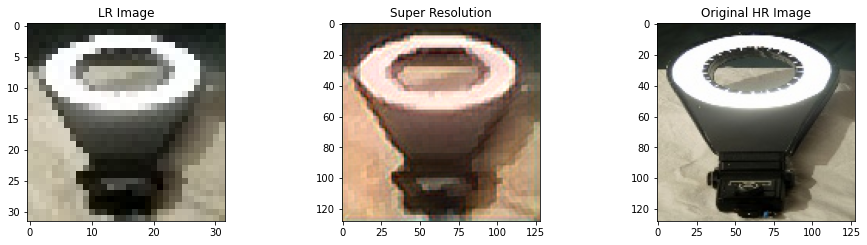

In [18]:
# Perform super resolution with saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_20.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# Select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# Generate image from source
gen_image = generator.predict(src_image)

# plot all three images
plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Super Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Original HR Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()